# Prepare the Bootstrap dataset

The purpose of this notebook is to create the **bootstrap** dataset, which serves as the foundational collection of curated paraphrases for the subsequent rounds and experimental conditions(see Section 4 in [Jorge et al](https://link.springer.com/chapter/10.1007/978-3-031-07472-1_15)). The **bootstrap** dataset involves the generation and curation of paraphrases for all 51 seeds in the experiment, saved in the **PSA.csv seed** dataset (see Datasets in [Jorge et al](https://link.springer.com/chapter/10.1007/978-3-031-07472-1_15)). This **bootstrap** dataset is shared across all experimental conditions, using a baseline prompt for paraphrase generation.

The creation of the **bootstrap** dataset is crucial to provide a consistent and comprehensive starting point for the subsequent stages of the experiment. It ensures that all experimental variations have access to a diverse set of paraphrases for each seed, facilitating meaningful comparisons and analyses in later rounds.

By establishing the **bootstrap** dataset, we lay the groundwork for exploring different *pattern selection strategies* and *prompts* to guide paraphrase generation in subsequent rounds. This notebook will execute the algorithm to build the high-quality dataset of curated paraphrases, setting the stage for further investigation and insights into the impact of various strategies on the paraphrasing process.

In [ ]:
import os
import pathlib
import json

# let's just make sure we are at the root
os.chdir(pathlib.Path().absolute().parent)
current_directory = os.getcwd()
new_directory = f"{current_directory}/Jorge_paper_replication"
os.chdir(new_directory)
print(f"Current working directory: {os.getcwd()}")

In [2]:
import random
import requests
from collections import Counter
import time
import math

import pandas as pd
import numpy as np
import stanza
import seaborn as sns
from tqdm import tqdm
from transformers import logging
from bert_score import score
import matplotlib.pyplot as plt
from termcolor import colored

from lib import metrics
from lib import utility as utlty
from lib import prompts_utility
from lib import gpt_utility

logging.set_verbosity_error()#suppressing the display of warning messages.

In [3]:
# Import stanza model
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency', tokenize_no_ssplit=True)

2023-08-15 17:04:32 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-08-15 17:04:33 INFO: Loading these models for language: en (English):
| Processor    | Package  |
---------------------------
| tokenize     | combined |
| pos          | combined |
| constituency | wsj      |

2023-08-15 17:04:33 INFO: Use device: cpu
2023-08-15 17:04:33 INFO: Loading: tokenize
2023-08-15 17:04:34 INFO: Loading: pos
2023-08-15 17:04:34 INFO: Loading: constituency
2023-08-15 17:04:34 INFO: Done loading processors!


# OpenAI credentials
Replace with your GPT API key and endpoint URL

In [4]:
# Replace with your personal GPT API key
API_KEY = ""

gpt_utility.define_credential(API_KEY)

### Read the input

In [5]:
input_file = f"{os.getcwd()}/input/PSA.csv"#test_data
df = pd.read_csv(input_file)
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns}")

new_column_names = {'row_pk': 'seed_id', 'parse_template': 'utterance_template'}
# Use the new_column_names dictionary to rename the columns
df.rename(columns=new_column_names, inplace=True)
print(f"New columns: {df.columns}")
df.head()

# test_df = df.head(2).copy()

Shape: (51, 6)
Columns: Index(['input_utterance', 'intent', 'parameters', 'parse_template', 'source',
       'row_pk'],
      dtype='object')
New columns: Index(['input_utterance', 'intent', 'parameters', 'utterance_template',
       'source', 'seed_id'],
      dtype='object')


,input_utterance,intent,parameters,utterance_template,source,seed_id
0,Terminate i-a541 now,EndEC2Instance,"[['VM', 'i-a541']]",( ROOT ( FRAG ( NP ) ( ADVP ) ) ),ParaQuality,1
1,Search for cooking videos,SearchWeb,"[['query', 'cooking videos']]",( ROOT ( S ( VP ) ) ),ParaQuality,2
2,Find most popular photos tagged #LOVE,SearchWeb,"[['Tag', '#LOVE']]",( ROOT ( S ( VP ) ) ),ParaQuality,3
3,Search for a few nice photos matching Opera Ho...,SearchWeb,"[['size', '1024px * 768px'], ['query', 'Opera ...",( ROOT ( FRAG ( S ) ( NP ) ) ),ParaQuality,4
4,Are the burglar alarms in the office malfuncti...,CheckDevice,"[['location', 'office']]",( ROOT ( SQ ( VBP ) ( NP ) ( ADJP ) ( . ) ) ),ParaQuality,5


#### Remove 'ROOT' label from the input syntax pattern

In [6]:
# Apply the custom processing function to the 'utterance_template' column
df['utterance_template'] = df['utterance_template'].apply(utlty.process_utterance_template)

In [7]:
df.head()

,input_utterance,intent,parameters,utterance_template,source,seed_id
0,Terminate i-a541 now,EndEC2Instance,"[['VM', 'i-a541']]",( FRAG ( NP ) ( ADVP ) ),ParaQuality,1
1,Search for cooking videos,SearchWeb,"[['query', 'cooking videos']]",( S ( VP ) ),ParaQuality,2
2,Find most popular photos tagged #LOVE,SearchWeb,"[['Tag', '#LOVE']]",( S ( VP ) ),ParaQuality,3
3,Search for a few nice photos matching Opera Ho...,SearchWeb,"[['size', '1024px * 768px'], ['query', 'Opera ...",( FRAG ( S ) ( NP ) ),ParaQuality,4
4,Are the burglar alarms in the office malfuncti...,CheckDevice,"[['location', 'office']]",( SQ ( VBP ) ( NP ) ( ADJP ) ( . ) ),ParaQuality,5


# Pattern representation and selection

#### Parse Tree Extraction
To capture and control syntax, we follow [Iyyer et al.](https://arxiv.org/pdf/1804.06059.pdf) and define a pattern as the top  two levels of a constituency parse tree.

#### Extract syntax pattern of input utterance
For the sake of consistency and to prevent any discrepancies in results among parsers, we have decided to re-extract the syntax pattern for each input_utterance. Subsequently, we will update the utterance_template column with the newly extracted syntax pattern to ensure uniformity in the DataFrame. By doing so, we can rely on accurate and up-to-date syntax patterns for further analysis and processing.

In [7]:
print(df.shape)
print(df.columns)
print("="*80)
utlty.get_all_syntax_patterns(nlp,df,'input_utterance','utterance_template')
df.head()[["seed_id", "input_utterance","utterance_template"]]

(51, 6)
Index(['input_utterance', 'intent', 'parameters', 'utterance_template',
       'source', 'seed_id'],
      dtype='object')


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.60it/s]


,seed_id,input_utterance,utterance_template
0,1,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) )
1,2,Search for cooking videos,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) )
2,3,Find most popular photos tagged #LOVE,( S ( S ( VP ) ) ( VP ( VBP ) ) )
3,4,Search for a few nice photos matching Opera Ho...,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) )
4,5,Are the burglar alarms in the office malfuncti...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...


# Baseline Paraphrase generation prompts

### Baseline workflow
Reference state-of-the-art workflow (see Section 3.1 in [Jorge et al](https://link.springer.com/chapter/10.1007/978-3-031-07472-1_15)). In this notebook we implement the **baseline** condition(see Section 4 Experimental conditions). The **baseline** condition comprises a workflow that uses the baseline prompt for paraphrase generation and random sampling for seed selection, which substitutes the each seed from the previous round (r−1)  with one correct paraphrase.

#### Data Integrity Checks

In [8]:
# extract seed utterance to paraphrase
seed_utterance = df['input_utterance'].tolist()
random_utterance = random.choice(seed_utterance)
print(f"Utterance sample: {random_utterance}")

assert df.shape == (51, 6), "Missing row in df"

print(f"Seed data: {df.shape}")

Utterance sample: I am looking for the latest scientific article related to Machine Learning
Seed data: (51, 6)


### A simple test
The purpose of this function is to submit a prepared prompt to GPT for paraphrasing and then fetch the generated paraphrases.

In [14]:
print(f"Seed Utternace to paraphrase: {seed_utterance[0]}")
prompt = prompts_utility.get_baseline_prompt(seed_utterance[0])

print()
print(f"The prompt:\n\n{prompt}")

# paraphrases = gpt_utility.generate_paraphrases_with_api(prompt)
paraphrases = gpt_utility.generate_paraphrases_with_retry(prompt,max_attempts=10)

print()
print("Generated paraphrases:\n")
for idx,p in enumerate(paraphrases):
    print(f"{idx+1}. {p}")

Seed Utternace to paraphrase: Terminate i-a541 now

The prompt:

[Instructions]
Suppose you have an intelligent device such as Amazon Alexa, Apple Siri, or Google Assistant. And this assistant can handle requests like "find places serving Italian food".
Given an original sentence representing a request, we ask you to provide 3 creative and different ways of saying the same request to the intelligent assistant. This task is known as paraphrasing or rewording. We ask you this so that the virtual assistant can understand the many ways a user can express the same request.

The paraphrases should not contain grammatical mistakes, and they should make sense.Provide your response in a JSON format. Do not provide any additional information except the JSON.Your JSON response should respect this structure:  {'paraphrases': ['paraphrase_1', 'paraphrase_2', Ellipsis, 'paraphrase_n']}

Paraphrase the following original sentence: "Terminate i-a541 now".
Paraphrases generated successfully after 0 att

# Main
Execute the workflow for a single round to generate the Bootstrap dataset.

In [9]:
# Set the number of rounds (r) for the data collection process
num_rounds = 8 # In the paper by Jorge et al., they gathered 24 paraphrases for each seed.

# Set the number of paraphrases to generate per prompt
num_parahrases = 3

#--------- Initialize X and Y for Round 1 ---------
# X = seed_utterances
X = df['input_utterance'].tolist()

# Y = input_paraphrase_corpus
Y = {}# initially the curated collection of paraphrases Ycan  be empty.

# Replace the following parameters with your predefined configuration:
cnfg_title = "Bootsrap Workflow Configuration"
print(colored(cnfg_title, 'green'))
print(colored("-" * len(cnfg_title), 'green'))
print()
# print(f"- Number of Workflow Rounds: {num_rounds}")
print(colored(f"- Number of paraphrases to generate per prompt: {num_parahrases}",'green'))
print(colored(f"- Prompt type: baseline_prompt", 'green'))
print()

# print(colored('hello', 'red'), colored('world', 'green'))
start_time = time.time()

# At the beginning of every round, the df_bootstrap DataFrame will be reset to align with the rows of the original df DataFrame.
# This deliberate step ensures uniform starting conditions for each iteration, allowing the grouping of the 24 paraphrases
# that will be produced across the 8 rounds for every seed utterance.
df_bootsrap = df.copy()

# This Python list comprises dataframes for each round's generated paraphrases corresponding to the 51 seed utterances.
# Ultimately, we will merge all eight dataframes into a single one named bootstrap_df, housing a total of 24 paraphrases
# for each of the 51 seed utterances.
dataframes_to_concat = []

for r in tqdm(range(1, num_rounds + 1), desc="Rounds"):
    print(f"Round {r}:")
    print()

    # p_map used to append generated paraphrases
    # p_syntax_map used to append syntax patterns of generated paraphrases
    # e.g. If we have to generate 2 paraphrases per prompt: p_map = {"p1": [], "p2": [], "p3": []}
    p_map, p_syntax_map = utlty.get_empty_dictionaries(num_parahrases)
    
    # Step 1: Paraphrase generation (using the OpenAI API)
    for seed_utterance in tqdm(X,, desc="Outer Loop"leave=False):
        # Step 2:  Crafting Prompts for each seed_utterance
        prompt = prompts_utility.get_baseline_prompt(seed_utterance,num_parahrases)
    
        # Step 3: Invoke GPT with the built prompt
        paraphrases = gpt_utility.generate_paraphrases_with_retry(prompt,10)
        paraphrases = utlty.checkgpt_generation_not_empty(paraphrases,num_parahrases)#check if GPT returned num_parahrases paraphrases
    
        # Step 4: Add elements from the 'para' list to their respective lists in the 'p_map' dictionary.
        for i, paraphrase in enumerate(paraphrases):
            key = f"p{i+1}"
    
            # Append current paraphrase
            p_map[key].append(paraphrase)
    
            # Extract and append the syntax pattern template of the current paraphrase.
            paraphrase_syntax_template,_,_ = utlty.extract_syntax_pattern(nlp, paraphrase)
            p_syntax_map[key].append(paraphrase_syntax_template)
    
    print()
    print(f"Paraphrase generation for Round {r} has been successfully completed.")
    print()
    # Step 5: add p_map and p_syntax_map as new columns in the df
    # Add P_Map Keys as New Columns to DataFrame, e.g.:
    # df["p1"] = pmap["p1"]
    # df["p2"] = pmap["p2"]
    # df["p3"] = pmap["p3"]
    for key in p_map.keys():
        df_bootsrap[key] =  pd.Series(p_map[key].copy())
        df_bootsrap[f"{key}_template"] =  pd.Series(p_syntax_map[key].copy())
    
    dataframes_to_concat.append(df_bootsrap)
    
    # Save the df_bootstrap to a file to ensure data persistence.
    # In case of any errors, this step prevents the need to restart all rounds from the beginning.
    current_time = time.strftime("%Y%m%d-%H%M%S")
    path_to_plot_file = os.path.join(os.getcwd(), f"checkpoints/create-bootstrap-raw-round{r}.csv")
    df_bootsrap.to_csv(path_to_plot_file, index=False)

    # Reset the df_bootstrap DataFrame for the next round.
    df_bootsrap = df.copy()

# Display the execution time, which can be valuable for comparison with crowdsourcing execution times.
end_time = time.time()
execution_time = end_time - start_time
print(colored('Execution time: ', 'green'), colored(f"{execution_time:.2f}", 'red'),colored(' seconds', 'green'))

# Concatenate the two dataframes
concatenated_df = pd.concat(dataframes_to_concat, ignore_index=True)
concatenated_df.shape

Bootsrap Workflow Configuration
-------------------------------

- Number of paraphrases to generate per prompt: 3
- Prompt type: baseline_prompt

Round 1:



  0%|                                                                                                                                                                                | 0/51 [00:00<?, ?it/s]

Paraphrases generated successfully after 0 attempts.


  2%|███▎                                                                                                                                                                    | 1/51 [00:22<18:29, 22.19s/it]

Paraphrases generated successfully after 0 attempts.


  4%|██████▌                                                                                                                                                                 | 2/51 [00:43<17:34, 21.53s/it]

Paraphrases generated successfully after 0 attempts.


  6%|█████████▉                                                                                                                                                              | 3/51 [01:00<15:50, 19.80s/it]

Paraphrases generated successfully after 0 attempts.


  8%|█████████████▏                                                                                                                                                          | 4/51 [01:15<13:50, 17.68s/it]

Paraphrases generated successfully after 0 attempts.


 10%|████████████████▍                                                                                                                                                       | 5/51 [01:18<09:38, 12.57s/it]

Paraphrases generated successfully after 0 attempts.


 12%|███████████████████▊                                                                                                                                                    | 6/51 [01:36<10:34, 14.11s/it]

Paraphrases generated successfully after 0 attempts.


 14%|███████████████████████                                                                                                                                                 | 7/51 [01:41<08:17, 11.30s/it]

Paraphrases generated successfully after 0 attempts.


 16%|██████████████████████████▎                                                                                                                                             | 8/51 [01:54<08:25, 11.75s/it]

Paraphrases generated successfully after 0 attempts.


 18%|█████████████████████████████▋                                                                                                                                          | 9/51 [02:05<08:08, 11.64s/it]

Paraphrases generated successfully after 0 attempts.


 20%|████████████████████████████████▋                                                                                                                                      | 10/51 [02:10<06:25,  9.41s/it]

Paraphrases generated successfully after 0 attempts.


 22%|████████████████████████████████████                                                                                                                                   | 11/51 [02:28<08:05, 12.13s/it]

Paraphrases generated successfully after 0 attempts.


 24%|███████████████████████████████████████▎                                                                                                                               | 12/51 [02:32<06:21,  9.78s/it]

Paraphrases generated successfully after 0 attempts.


 25%|██████████████████████████████████████████▌                                                                                                                            | 13/51 [02:35<04:44,  7.50s/it]

Paraphrases generated successfully after 0 attempts.


 27%|█████████████████████████████████████████████▊                                                                                                                         | 14/51 [03:03<08:34, 13.89s/it]

Paraphrases generated successfully after 0 attempts.


 29%|█████████████████████████████████████████████████                                                                                                                      | 15/51 [03:34<11:27, 19.09s/it]

Paraphrases generated successfully after 0 attempts.


 31%|████████████████████████████████████████████████████▍                                                                                                                  | 16/51 [03:52<10:51, 18.61s/it]

Paraphrases generated successfully after 0 attempts.


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 17/51 [04:03<09:15, 16.33s/it]

Paraphrases generated successfully after 0 attempts.


 35%|██████████████████████████████████████████████████████████▉                                                                                                            | 18/51 [04:07<07:02, 12.81s/it]

Paraphrases generated successfully after 0 attempts.


 37%|██████████████████████████████████████████████████████████████▏                                                                                                        | 19/51 [04:11<05:18,  9.96s/it]

Paraphrases generated successfully after 0 attempts.


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 20/51 [04:29<06:24, 12.40s/it]

Paraphrases generated successfully after 0 attempts.


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                  | 21/51 [04:39<05:53, 11.77s/it]

Paraphrases generated successfully after 0 attempts.


 43%|████████████████████████████████████████████████████████████████████████                                                                                               | 22/51 [04:49<05:27, 11.31s/it]

Paraphrases generated successfully after 0 attempts.


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                           | 23/51 [05:07<06:06, 13.07s/it]

Paraphrases generated successfully after 0 attempts.


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                        | 24/51 [05:13<04:58, 11.05s/it]

Paraphrases generated successfully after 0 attempts.


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 25/51 [05:18<03:59,  9.21s/it]

Paraphrases generated successfully after 0 attempts.


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 26/51 [05:57<07:35, 18.23s/it]

Request timed out. Retrying in 5 seconds...
Paraphrases generated successfully after 0 attempts.


 53%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 27/51 [16:16<1:19:19, 198.30s/it]

Paraphrases generated successfully after 0 attempts.


 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 28/51 [16:19<53:35, 139.79s/it]

Paraphrases generated successfully after 0 attempts.


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 29/51 [16:30<37:07, 101.23s/it]

Paraphrases generated successfully after 0 attempts.


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 30/51 [16:35<25:21, 72.44s/it]

Paraphrases generated successfully after 0 attempts.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 31/51 [16:40<17:19, 51.96s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 32/51 [17:30<16:19, 51.56s/it]

Paraphrases generated successfully after 0 attempts.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 33/51 [17:34<11:08, 37.14s/it]

Paraphrases generated successfully after 0 attempts.


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/51 [18:09<10:23, 36.68s/it]

Paraphrases generated successfully after 0 attempts.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 35/51 [18:12<07:05, 26.62s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 36/51 [19:40<11:13, 44.88s/it]

Paraphrases generated successfully after 0 attempts.


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 37/51 [19:50<08:01, 34.38s/it]

Paraphrases generated successfully after 0 attempts.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 38/51 [19:54<05:27, 25.19s/it]

Paraphrases generated successfully after 0 attempts.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 39/51 [20:12<04:38, 23.23s/it]

Paraphrases generated successfully after 0 attempts.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 40/51 [20:38<04:23, 23.96s/it]

Paraphrases generated successfully after 0 attempts.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 41/51 [20:49<03:21, 20.20s/it]

Paraphrases generated successfully after 0 attempts.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 42/51 [20:54<02:18, 15.42s/it]

Paraphrases generated successfully after 0 attempts.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 43/51 [21:07<01:59, 14.97s/it]

Paraphrases generated successfully after 0 attempts.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 44/51 [21:18<01:35, 13.67s/it]

Paraphrases generated successfully after 0 attempts.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 45/51 [21:22<01:03, 10.62s/it]

Paraphrases generated successfully after 0 attempts.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 46/51 [21:32<00:52, 10.43s/it]

Paraphrases generated successfully after 0 attempts.


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 47/51 [21:34<00:32,  8.13s/it]

Paraphrases generated successfully after 0 attempts.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 48/51 [21:45<00:26,  8.94s/it]

Paraphrases generated successfully after 0 attempts.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 49/51 [21:55<00:18,  9.25s/it]

Paraphrases generated successfully after 0 attempts.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 50/51 [22:18<00:13, 13.21s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [23:06<00:00, 27.18s/it]



Paraphrase generation for Round 1 has been successfully completed.

Round 2:



  0%|                                                                                                                                                                                | 0/51 [00:00<?, ?it/s]

Paraphrases generated successfully after 0 attempts.


  2%|███▎                                                                                                                                                                    | 1/51 [00:01<01:37,  1.94s/it]

Paraphrases generated successfully after 0 attempts.


  4%|██████▌                                                                                                                                                                 | 2/51 [00:23<11:01, 13.50s/it]

Paraphrases generated successfully after 0 attempts.


  6%|█████████▉                                                                                                                                                              | 3/51 [00:26<06:57,  8.71s/it]

Paraphrases generated successfully after 0 attempts.


  8%|█████████████▏                                                                                                                                                          | 4/51 [00:39<08:03, 10.29s/it]

Paraphrases generated successfully after 0 attempts.


 10%|████████████████▍                                                                                                                                                       | 5/51 [00:42<05:54,  7.70s/it]

Paraphrases generated successfully after 0 attempts.


 12%|███████████████████▊                                                                                                                                                    | 6/51 [01:05<09:41, 12.92s/it]

Paraphrases generated successfully after 0 attempts.


 14%|███████████████████████                                                                                                                                                 | 7/51 [01:09<07:23, 10.08s/it]

Paraphrases generated successfully after 0 attempts.


 16%|██████████████████████████▎                                                                                                                                             | 8/51 [01:13<05:54,  8.24s/it]

Paraphrases generated successfully after 0 attempts.


 18%|█████████████████████████████▋                                                                                                                                          | 9/51 [01:25<06:34,  9.39s/it]

Paraphrases generated successfully after 0 attempts.


 20%|████████████████████████████████▋                                                                                                                                      | 10/51 [01:36<06:35,  9.66s/it]

Paraphrases generated successfully after 0 attempts.


 22%|████████████████████████████████████                                                                                                                                   | 11/51 [01:47<06:47, 10.20s/it]

Paraphrases generated successfully after 0 attempts.


 24%|███████████████████████████████████████▎                                                                                                                               | 12/51 [01:50<05:09,  7.94s/it]

Paraphrases generated successfully after 0 attempts.


 25%|██████████████████████████████████████████▌                                                                                                                            | 13/51 [02:25<10:11, 16.10s/it]

Paraphrases generated successfully after 0 attempts.


 27%|█████████████████████████████████████████████▊                                                                                                                         | 14/51 [02:27<07:18, 11.85s/it]

Paraphrases generated successfully after 0 attempts.


 29%|█████████████████████████████████████████████████                                                                                                                      | 15/51 [02:44<08:06, 13.53s/it]

Paraphrases generated successfully after 0 attempts.


 31%|████████████████████████████████████████████████████▍                                                                                                                  | 16/51 [02:55<07:24, 12.71s/it]

Paraphrases generated successfully after 0 attempts.


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 17/51 [02:58<05:38,  9.95s/it]

Paraphrases generated successfully after 0 attempts.


 35%|██████████████████████████████████████████████████████████▉                                                                                                            | 18/51 [03:02<04:21,  7.92s/it]

Paraphrases generated successfully after 0 attempts.


 37%|██████████████████████████████████████████████████████████████▏                                                                                                        | 19/51 [03:04<03:19,  6.25s/it]

Paraphrases generated successfully after 0 attempts.


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 20/51 [03:07<02:43,  5.26s/it]

Paraphrases generated successfully after 0 attempts.


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                  | 21/51 [03:11<02:26,  4.88s/it]

Paraphrases generated successfully after 0 attempts.


 43%|████████████████████████████████████████████████████████████████████████                                                                                               | 22/51 [03:21<03:09,  6.52s/it]

Paraphrases generated successfully after 0 attempts.


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                           | 23/51 [03:24<02:27,  5.25s/it]

Paraphrases generated successfully after 0 attempts.


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                        | 24/51 [03:30<02:27,  5.46s/it]

Paraphrases generated successfully after 0 attempts.


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 25/51 [03:33<02:08,  4.96s/it]

Paraphrases generated successfully after 0 attempts.


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 26/51 [03:51<03:37,  8.70s/it]

Paraphrases generated successfully after 0 attempts.


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 27/51 [03:54<02:49,  7.04s/it]

Paraphrases generated successfully after 0 attempts.


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 28/51 [03:57<02:15,  5.90s/it]

Paraphrases generated successfully after 0 attempts.


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 29/51 [04:14<03:23,  9.25s/it]

Paraphrases generated successfully after 0 attempts.


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 30/51 [04:36<04:35, 13.12s/it]

Paraphrases generated successfully after 0 attempts.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 31/51 [04:40<03:25, 10.28s/it]

Paraphrases generated successfully after 0 attempts.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 32/51 [05:23<06:24, 20.22s/it]

Paraphrases generated successfully after 0 attempts.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 33/51 [05:35<05:17, 17.66s/it]

Paraphrases generated successfully after 0 attempts.


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/51 [06:12<06:39, 23.51s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 35/51 [06:59<08:05, 30.34s/it]

Paraphrases generated successfully after 0 attempts.


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 36/51 [07:10<06:08, 24.60s/it]

Paraphrases generated successfully after 0 attempts.


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 37/51 [07:48<06:41, 28.71s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 38/51 [08:41<07:48, 36.06s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 39/51 [09:33<08:10, 40.85s/it]

Paraphrases generated successfully after 0 attempts.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 40/51 [09:37<05:26, 29.64s/it]

Paraphrases generated successfully after 0 attempts.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 41/51 [09:50<04:05, 24.57s/it]

Paraphrases generated successfully after 0 attempts.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 42/51 [09:54<02:46, 18.52s/it]

Paraphrases generated successfully after 0 attempts.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 43/51 [09:59<01:56, 14.50s/it]

Paraphrases generated successfully after 0 attempts.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 44/51 [10:03<01:19, 11.35s/it]

Paraphrases generated successfully after 0 attempts.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 45/51 [10:07<00:55,  9.20s/it]

Paraphrases generated successfully after 0 attempts.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 46/51 [10:33<01:10, 14.15s/it]

Paraphrases generated successfully after 0 attempts.


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 47/51 [10:50<01:00, 15.06s/it]

Paraphrases generated successfully after 0 attempts.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 48/51 [11:30<01:07, 22.46s/it]

Paraphrases generated successfully after 0 attempts.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 49/51 [11:33<00:33, 16.61s/it]

Paraphrases generated successfully after 0 attempts.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 50/51 [11:48<00:16, 16.16s/it]

Paraphrases generated successfully after 0 attempts.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [12:03<00:00, 14.18s/it]



Paraphrase generation for Round 2 has been successfully completed.

Round 3:



  0%|                                                                                                                                                                                | 0/51 [00:00<?, ?it/s]

Paraphrases generated successfully after 0 attempts.


  2%|███▎                                                                                                                                                                    | 1/51 [00:01<01:33,  1.87s/it]

Paraphrases generated successfully after 0 attempts.


  4%|██████▌                                                                                                                                                                 | 2/51 [00:04<01:41,  2.08s/it]

Paraphrases generated successfully after 0 attempts.


  6%|█████████▉                                                                                                                                                              | 3/51 [00:21<07:10,  8.97s/it]

Paraphrases generated successfully after 0 attempts.


  8%|█████████████▏                                                                                                                                                          | 4/51 [00:26<05:56,  7.59s/it]

Paraphrases generated successfully after 0 attempts.


 10%|████████████████▍                                                                                                                                                       | 5/51 [00:29<04:35,  5.99s/it]

Paraphrases generated successfully after 0 attempts.


 12%|███████████████████▊                                                                                                                                                    | 6/51 [00:32<03:42,  4.94s/it]

API server is overloaded or not ready. Retrying in 5 seconds...
Paraphrases generated successfully after 0 attempts.


 14%|███████████████████████                                                                                                                                                 | 7/51 [00:43<05:04,  6.93s/it]

Paraphrases generated successfully after 0 attempts.


 16%|██████████████████████████▎                                                                                                                                             | 8/51 [00:48<04:24,  6.16s/it]

Paraphrases generated successfully after 0 attempts.


 18%|█████████████████████████████▋                                                                                                                                          | 9/51 [00:52<03:55,  5.61s/it]

Paraphrases generated successfully after 0 attempts.


 20%|████████████████████████████████▋                                                                                                                                      | 10/51 [00:55<03:15,  4.76s/it]

Paraphrases generated successfully after 0 attempts.


 22%|████████████████████████████████████                                                                                                                                   | 11/51 [01:06<04:24,  6.61s/it]

Paraphrases generated successfully after 0 attempts.


 24%|███████████████████████████████████████▎                                                                                                                               | 12/51 [01:24<06:36, 10.16s/it]

Paraphrases generated successfully after 0 attempts.


 25%|██████████████████████████████████████████▌                                                                                                                            | 13/51 [01:39<07:24, 11.69s/it]

Paraphrases generated successfully after 0 attempts.


 27%|█████████████████████████████████████████████▊                                                                                                                         | 14/51 [01:41<05:23,  8.75s/it]

Paraphrases generated successfully after 0 attempts.


 29%|█████████████████████████████████████████████████                                                                                                                      | 15/51 [01:45<04:17,  7.17s/it]

Paraphrases generated successfully after 0 attempts.


 31%|████████████████████████████████████████████████████▍                                                                                                                  | 16/51 [01:56<04:48,  8.23s/it]

Paraphrases generated successfully after 0 attempts.


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 17/51 [02:07<05:12,  9.19s/it]

Paraphrases generated successfully after 0 attempts.


 35%|██████████████████████████████████████████████████████████▉                                                                                                            | 18/51 [02:19<05:31, 10.06s/it]

Paraphrases generated successfully after 0 attempts.


 37%|██████████████████████████████████████████████████████████████▏                                                                                                        | 19/51 [02:29<05:22, 10.07s/it]

Paraphrases generated successfully after 0 attempts.


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 20/51 [02:40<05:20, 10.33s/it]

Paraphrases generated successfully after 0 attempts.


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                  | 21/51 [02:44<04:11,  8.39s/it]

Paraphrases generated successfully after 0 attempts.


 43%|████████████████████████████████████████████████████████████████████████                                                                                               | 22/51 [02:54<04:19,  8.96s/it]

Paraphrases generated successfully after 0 attempts.


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                           | 23/51 [03:13<05:29, 11.77s/it]

Paraphrases generated successfully after 0 attempts.


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                        | 24/51 [03:18<04:26,  9.88s/it]

Paraphrases generated successfully after 0 attempts.


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 25/51 [03:30<04:33, 10.52s/it]

Paraphrases generated successfully after 0 attempts.


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 26/51 [03:54<06:02, 14.50s/it]

Paraphrases generated successfully after 0 attempts.


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 27/51 [03:57<04:25, 11.04s/it]

Paraphrases generated successfully after 0 attempts.


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 28/51 [04:07<04:07, 10.77s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 29/51 [05:10<09:43, 26.52s/it]

Paraphrases generated successfully after 0 attempts.


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 30/51 [05:25<08:05, 23.13s/it]

Paraphrases generated successfully after 0 attempts.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 31/51 [05:38<06:36, 19.85s/it]

Paraphrases generated successfully after 0 attempts.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 32/51 [05:49<05:26, 17.21s/it]

Paraphrases generated successfully after 0 attempts.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 33/51 [05:53<03:58, 13.26s/it]

Paraphrases generated successfully after 0 attempts.


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/51 [05:56<02:55, 10.31s/it]

Paraphrases generated successfully after 0 attempts.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 35/51 [05:59<02:10,  8.14s/it]

Paraphrases generated successfully after 0 attempts.


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 36/51 [06:11<02:17,  9.15s/it]

Paraphrases generated successfully after 0 attempts.


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 37/51 [06:14<01:43,  7.41s/it]

Paraphrases generated successfully after 0 attempts.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 38/51 [06:17<01:18,  6.07s/it]

Paraphrases generated successfully after 0 attempts.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 39/51 [06:35<01:56,  9.68s/it]

Paraphrases generated successfully after 0 attempts.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 40/51 [06:46<01:49,  9.97s/it]

Paraphrases generated successfully after 0 attempts.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 41/51 [07:06<02:09, 12.96s/it]

Paraphrases generated successfully after 0 attempts.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 42/51 [07:16<01:50, 12.32s/it]

Paraphrases generated successfully after 0 attempts.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 43/51 [07:21<01:20, 10.03s/it]

Paraphrases generated successfully after 0 attempts.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 44/51 [07:32<01:12, 10.30s/it]

Paraphrases generated successfully after 0 attempts.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 45/51 [07:50<01:15, 12.63s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 46/51 [08:43<02:03, 24.68s/it]

Paraphrases generated successfully after 0 attempts.


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 47/51 [09:07<01:37, 24.35s/it]

Paraphrases generated successfully after 0 attempts.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 48/51 [09:16<00:59, 19.93s/it]

Paraphrases generated successfully after 0 attempts.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 49/51 [09:26<00:33, 16.85s/it]

Paraphrases generated successfully after 0 attempts.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 50/51 [09:29<00:12, 12.61s/it]

Paraphrases generated successfully after 0 attempts.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [09:36<00:00, 11.31s/it]



Paraphrase generation for Round 3 has been successfully completed.

Round 4:



  0%|                                                                                                                                                                                | 0/51 [00:00<?, ?it/s]

Paraphrases generated successfully after 0 attempts.


  2%|███▎                                                                                                                                                                    | 1/51 [00:14<12:21, 14.83s/it]

Paraphrases generated successfully after 0 attempts.


  4%|██████▌                                                                                                                                                                 | 2/51 [00:17<06:13,  7.61s/it]

Paraphrases generated successfully after 0 attempts.


  6%|█████████▉                                                                                                                                                              | 3/51 [00:27<07:02,  8.80s/it]

Paraphrases generated successfully after 0 attempts.


  8%|█████████████▏                                                                                                                                                          | 4/51 [00:41<08:19, 10.62s/it]

Paraphrases generated successfully after 0 attempts.


 10%|████████████████▍                                                                                                                                                       | 5/51 [00:57<09:51, 12.85s/it]

Paraphrases generated successfully after 0 attempts.


 12%|███████████████████▊                                                                                                                                                    | 6/51 [01:00<06:58,  9.31s/it]

Paraphrases generated successfully after 0 attempts.


 14%|███████████████████████                                                                                                                                                 | 7/51 [01:12<07:29, 10.22s/it]

Paraphrases generated successfully after 0 attempts.


 16%|██████████████████████████▎                                                                                                                                             | 8/51 [01:24<07:47, 10.87s/it]

Paraphrases generated successfully after 0 attempts.


 18%|█████████████████████████████▋                                                                                                                                          | 9/51 [01:28<05:59,  8.55s/it]

Paraphrases generated successfully after 0 attempts.


 20%|████████████████████████████████▋                                                                                                                                      | 10/51 [01:31<04:43,  6.90s/it]

Paraphrases generated successfully after 0 attempts.


 22%|████████████████████████████████████                                                                                                                                   | 11/51 [01:35<03:59,  6.00s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


 24%|███████████████████████████████████████▎                                                                                                                               | 12/51 [02:25<12:33, 19.33s/it]

Paraphrases generated successfully after 0 attempts.


 25%|██████████████████████████████████████████▌                                                                                                                            | 13/51 [02:33<10:07, 15.98s/it]

Paraphrases generated successfully after 0 attempts.


 27%|█████████████████████████████████████████████▊                                                                                                                         | 14/51 [02:47<09:32, 15.48s/it]

Paraphrases generated successfully after 0 attempts.


 29%|█████████████████████████████████████████████████                                                                                                                      | 15/51 [02:51<07:14, 12.08s/it]

Paraphrases generated successfully after 0 attempts.


 31%|████████████████████████████████████████████████████▍                                                                                                                  | 16/51 [03:02<06:52, 11.78s/it]

Paraphrases generated successfully after 0 attempts.


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 17/51 [03:06<05:20,  9.43s/it]

Paraphrases generated successfully after 0 attempts.


 35%|██████████████████████████████████████████████████████████▉                                                                                                            | 18/51 [03:17<05:27,  9.91s/it]

Paraphrases generated successfully after 0 attempts.


 37%|██████████████████████████████████████████████████████████████▏                                                                                                        | 19/51 [03:20<04:04,  7.64s/it]

Paraphrases generated successfully after 0 attempts.


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 20/51 [03:30<04:24,  8.54s/it]

Paraphrases generated successfully after 0 attempts.


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                  | 21/51 [03:41<04:39,  9.30s/it]

Paraphrases generated successfully after 0 attempts.


 43%|████████████████████████████████████████████████████████████████████████                                                                                               | 22/51 [03:44<03:31,  7.31s/it]

Paraphrases generated successfully after 0 attempts.


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                           | 23/51 [03:54<03:45,  8.07s/it]

API server is overloaded or not ready. Retrying in 5 seconds...
Paraphrases generated successfully after 0 attempts.


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                        | 24/51 [04:05<04:02,  8.99s/it]

Paraphrases generated successfully after 0 attempts.


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 25/51 [04:17<04:17,  9.89s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 26/51 [05:03<08:33, 20.56s/it]

Paraphrases generated successfully after 0 attempts.


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 27/51 [05:13<07:02, 17.62s/it]

Paraphrases generated successfully after 0 attempts.


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 28/51 [05:16<05:03, 13.20s/it]

Paraphrases generated successfully after 0 attempts.


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 29/51 [05:19<03:43, 10.17s/it]

Paraphrases generated successfully after 0 attempts.


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 30/51 [05:25<03:03,  8.75s/it]

Paraphrases generated successfully after 0 attempts.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 31/51 [05:43<03:51, 11.60s/it]

Paraphrases generated successfully after 0 attempts.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 32/51 [05:47<02:58,  9.37s/it]

Paraphrases generated successfully after 0 attempts.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 33/51 [05:52<02:23,  7.98s/it]

Paraphrases generated successfully after 0 attempts.


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/51 [06:12<03:16, 11.54s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 35/51 [07:12<06:58, 26.15s/it]

Paraphrases generated successfully after 0 attempts.


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 36/51 [07:38<06:31, 26.09s/it]

Paraphrases generated successfully after 0 attempts.


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 37/51 [07:41<04:29, 19.26s/it]

Paraphrases generated successfully after 0 attempts.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 38/51 [08:21<05:31, 25.47s/it]

Paraphrases generated successfully after 0 attempts.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 39/51 [08:24<03:45, 18.81s/it]

Paraphrases generated successfully after 0 attempts.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 40/51 [08:28<02:37, 14.29s/it]

Paraphrases generated successfully after 0 attempts.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 41/51 [08:40<02:15, 13.54s/it]

Paraphrases generated successfully after 0 attempts.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 42/51 [08:44<01:35, 10.56s/it]

Paraphrases generated successfully after 0 attempts.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 43/51 [08:49<01:11,  8.95s/it]

Paraphrases generated successfully after 0 attempts.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 44/51 [08:53<00:51,  7.42s/it]

Paraphrases generated successfully after 0 attempts.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 45/51 [09:03<00:49,  8.28s/it]

Paraphrases generated successfully after 0 attempts.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 46/51 [09:14<00:45,  9.10s/it]

Paraphrases generated successfully after 0 attempts.


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 47/51 [09:16<00:28,  7.07s/it]

Paraphrases generated successfully after 0 attempts.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 48/51 [09:27<00:24,  8.03s/it]

Paraphrases generated successfully after 0 attempts.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 49/51 [09:30<00:13,  6.66s/it]

Paraphrases generated successfully after 0 attempts.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 50/51 [09:46<00:09,  9.59s/it]

Paraphrases generated successfully after 0 attempts.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [09:56<00:00, 11.69s/it]



Paraphrase generation for Round 4 has been successfully completed.

Round 5:



  0%|                                                                                                                                                                                | 0/51 [00:00<?, ?it/s]

Paraphrases generated successfully after 0 attempts.


  2%|███▎                                                                                                                                                                    | 1/51 [00:08<06:55,  8.30s/it]

Paraphrases generated successfully after 0 attempts.


  4%|██████▌                                                                                                                                                                 | 2/51 [00:10<03:43,  4.55s/it]

Paraphrases generated successfully after 0 attempts.


  6%|█████████▉                                                                                                                                                              | 3/51 [00:28<08:40, 10.84s/it]

Paraphrases generated successfully after 0 attempts.


  8%|█████████████▏                                                                                                                                                          | 4/51 [00:33<06:46,  8.65s/it]

Paraphrases generated successfully after 0 attempts.


 10%|████████████████▍                                                                                                                                                       | 5/51 [00:36<04:59,  6.50s/it]

Paraphrases generated successfully after 0 attempts.


 12%|███████████████████▊                                                                                                                                                    | 6/51 [00:39<03:59,  5.33s/it]

Paraphrases generated successfully after 0 attempts.


 14%|███████████████████████                                                                                                                                                 | 7/51 [00:43<03:36,  4.91s/it]

Paraphrases generated successfully after 0 attempts.


 16%|██████████████████████████▎                                                                                                                                             | 8/51 [00:56<05:17,  7.38s/it]

Paraphrases generated successfully after 0 attempts.


 18%|█████████████████████████████▋                                                                                                                                          | 9/51 [01:07<05:58,  8.53s/it]

Paraphrases generated successfully after 0 attempts.


 20%|████████████████████████████████▋                                                                                                                                      | 10/51 [01:10<04:36,  6.75s/it]

Paraphrases generated successfully after 0 attempts.


 22%|████████████████████████████████████                                                                                                                                   | 11/51 [01:14<04:03,  6.09s/it]

Paraphrases generated successfully after 0 attempts.


 24%|███████████████████████████████████████▎                                                                                                                               | 12/51 [01:39<07:40, 11.80s/it]

Paraphrases generated successfully after 0 attempts.


 25%|██████████████████████████████████████████▌                                                                                                                            | 13/51 [01:48<06:52, 10.87s/it]

Paraphrases generated successfully after 0 attempts.


 27%|█████████████████████████████████████████████▊                                                                                                                         | 14/51 [01:50<05:06,  8.28s/it]

Paraphrases generated successfully after 0 attempts.


 29%|█████████████████████████████████████████████████                                                                                                                      | 15/51 [01:53<03:54,  6.52s/it]

Paraphrases generated successfully after 0 attempts.


 31%|████████████████████████████████████████████████████▍                                                                                                                  | 16/51 [02:03<04:28,  7.68s/it]

Paraphrases generated successfully after 0 attempts.


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 17/51 [02:07<03:39,  6.45s/it]

Paraphrases generated successfully after 0 attempts.


 35%|██████████████████████████████████████████████████████████▉                                                                                                            | 18/51 [02:18<04:22,  7.96s/it]

Paraphrases generated successfully after 0 attempts.


 37%|██████████████████████████████████████████████████████████████▏                                                                                                        | 19/51 [02:21<03:25,  6.43s/it]

Paraphrases generated successfully after 0 attempts.


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 20/51 [02:39<05:08,  9.96s/it]

Paraphrases generated successfully after 0 attempts.


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                  | 21/51 [02:50<05:11, 10.37s/it]

Paraphrases generated successfully after 0 attempts.


 43%|████████████████████████████████████████████████████████████████████████                                                                                               | 22/51 [03:24<08:25, 17.44s/it]

Paraphrases generated successfully after 0 attempts.


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                           | 23/51 [04:03<11:07, 23.83s/it]

Paraphrases generated successfully after 0 attempts.


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                        | 24/51 [04:26<10:37, 23.60s/it]

Paraphrases generated successfully after 0 attempts.


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 25/51 [04:31<07:44, 17.85s/it]

Paraphrases generated successfully after 0 attempts.


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 26/51 [04:41<06:27, 15.50s/it]

Paraphrases generated successfully after 0 attempts.


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 27/51 [04:51<05:36, 14.01s/it]

Paraphrases generated successfully after 0 attempts.


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 28/51 [05:01<04:55, 12.86s/it]

Paraphrases generated successfully after 0 attempts.


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 29/51 [05:19<05:18, 14.46s/it]

Paraphrases generated successfully after 0 attempts.


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 30/51 [05:25<04:09, 11.88s/it]

Paraphrases generated successfully after 0 attempts.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 31/51 [05:29<03:09,  9.45s/it]

Paraphrases generated successfully after 0 attempts.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 32/51 [05:51<04:09, 13.14s/it]

Paraphrases generated successfully after 0 attempts.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 33/51 [05:55<03:07, 10.43s/it]

API server is overloaded or not ready. Retrying in 5 seconds...
Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/51 [06:44<06:11, 21.87s/it]

Paraphrases generated successfully after 0 attempts.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 35/51 [06:55<04:57, 18.62s/it]

Paraphrases generated successfully after 0 attempts.


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 36/51 [07:00<03:37, 14.52s/it]

Paraphrases generated successfully after 0 attempts.


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 37/51 [07:03<02:35, 11.11s/it]

Paraphrases generated successfully after 0 attempts.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 38/51 [07:06<01:53,  8.72s/it]

Paraphrases generated successfully after 0 attempts.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 39/51 [07:09<01:24,  7.03s/it]

Paraphrases generated successfully after 0 attempts.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 40/51 [07:19<01:28,  8.03s/it]

Paraphrases generated successfully after 0 attempts.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 41/51 [07:24<01:09,  6.95s/it]

Paraphrases generated successfully after 0 attempts.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 42/51 [07:35<01:13,  8.11s/it]

Paraphrases generated successfully after 0 attempts.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 43/51 [08:10<02:11, 16.38s/it]

Paraphrases generated successfully after 0 attempts.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 44/51 [08:20<01:41, 14.45s/it]

Paraphrases generated successfully after 0 attempts.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 45/51 [08:39<01:34, 15.77s/it]

Request timed out. Retrying in 5 seconds...
Paraphrases generated successfully after 0 attempts.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 46/51 [19:02<16:29, 197.95s/it]

Paraphrases generated successfully after 0 attempts.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 47/51 [19:05<09:17, 139.42s/it]

Paraphrases generated successfully after 0 attempts.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 48/51 [19:08<04:55, 98.52s/it]

Paraphrases generated successfully after 0 attempts.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 49/51 [19:40<02:37, 78.68s/it]

Paraphrases generated successfully after 0 attempts.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 50/51 [19:43<00:55, 55.84s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [20:33<00:00, 24.18s/it]



Paraphrase generation for Round 5 has been successfully completed.

Round 6:



  0%|                                                                                                                                                                                | 0/51 [00:00<?, ?it/s]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


  2%|███▎                                                                                                                                                                    | 1/51 [01:07<56:01, 67.24s/it]

Paraphrases generated successfully after 0 attempts.


  4%|██████▌                                                                                                                                                                 | 2/51 [01:09<23:43, 29.05s/it]

Paraphrases generated successfully after 0 attempts.


  6%|█████████▉                                                                                                                                                              | 3/51 [01:12<13:38, 17.06s/it]

Paraphrases generated successfully after 0 attempts.


  8%|█████████████▏                                                                                                                                                          | 4/51 [01:33<14:42, 18.78s/it]

Paraphrases generated successfully after 0 attempts.


 10%|████████████████▍                                                                                                                                                       | 5/51 [01:36<10:00, 13.05s/it]

Paraphrases generated successfully after 0 attempts.


 12%|███████████████████▊                                                                                                                                                    | 6/51 [02:03<13:16, 17.70s/it]

Paraphrases generated successfully after 0 attempts.


 14%|███████████████████████                                                                                                                                                 | 7/51 [02:15<11:35, 15.80s/it]

Paraphrases generated successfully after 0 attempts.


 16%|██████████████████████████▎                                                                                                                                             | 8/51 [02:42<13:59, 19.52s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


 18%|█████████████████████████████▋                                                                                                                                          | 9/51 [04:03<26:57, 38.52s/it]

Paraphrases generated successfully after 0 attempts.


 20%|████████████████████████████████▋                                                                                                                                      | 10/51 [04:06<18:56, 27.72s/it]

Paraphrases generated successfully after 0 attempts.


 22%|████████████████████████████████████                                                                                                                                   | 11/51 [04:26<16:47, 25.20s/it]

Paraphrases generated successfully after 0 attempts.


 24%|███████████████████████████████████████▎                                                                                                                               | 12/51 [04:50<16:08, 24.85s/it]

Paraphrases generated successfully after 0 attempts.


 25%|██████████████████████████████████████████▌                                                                                                                            | 13/51 [04:58<12:36, 19.91s/it]

Paraphrases generated successfully after 0 attempts.


 27%|█████████████████████████████████████████████▊                                                                                                                         | 14/51 [05:07<10:10, 16.49s/it]

Paraphrases generated successfully after 0 attempts.


 29%|█████████████████████████████████████████████████                                                                                                                      | 15/51 [05:10<07:29, 12.50s/it]

Paraphrases generated successfully after 0 attempts.


 31%|████████████████████████████████████████████████████▍                                                                                                                  | 16/51 [05:44<10:59, 18.85s/it]

Paraphrases generated successfully after 0 attempts.


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 17/51 [05:48<08:09, 14.39s/it]

Paraphrases generated successfully after 0 attempts.


 35%|██████████████████████████████████████████████████████████▉                                                                                                            | 18/51 [05:52<06:12, 11.28s/it]

Paraphrases generated successfully after 0 attempts.


 37%|██████████████████████████████████████████████████████████████▏                                                                                                        | 19/51 [05:55<04:40,  8.76s/it]

Paraphrases generated successfully after 0 attempts.


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 20/51 [05:57<03:37,  7.01s/it]

Paraphrases generated successfully after 0 attempts.


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                  | 21/51 [06:09<04:10,  8.34s/it]

Paraphrases generated successfully after 0 attempts.


 43%|████████████████████████████████████████████████████████████████████████                                                                                               | 22/51 [06:49<08:37, 17.83s/it]

Paraphrases generated successfully after 0 attempts.


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                           | 23/51 [06:52<06:14, 13.36s/it]

Paraphrases generated successfully after 0 attempts.


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                        | 24/51 [07:24<08:31, 18.93s/it]

Paraphrases generated successfully after 0 attempts.


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 25/51 [07:28<06:18, 14.57s/it]

Paraphrases generated successfully after 0 attempts.


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 26/51 [07:31<04:38, 11.14s/it]

Paraphrases generated successfully after 0 attempts.


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 27/51 [07:34<03:27,  8.63s/it]

Paraphrases generated successfully after 0 attempts.


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 28/51 [07:37<02:40,  6.99s/it]

Paraphrases generated successfully after 0 attempts.


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 29/51 [07:41<02:10,  5.95s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 30/51 [09:04<10:12, 29.18s/it]

Paraphrases generated successfully after 0 attempts.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 31/51 [09:07<07:05, 21.28s/it]

Paraphrases generated successfully after 0 attempts.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 32/51 [09:48<08:35, 27.11s/it]

Paraphrases generated successfully after 0 attempts.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 33/51 [09:51<06:01, 20.09s/it]

Paraphrases generated successfully after 0 attempts.


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/51 [09:56<04:20, 15.31s/it]

Paraphrases generated successfully after 0 attempts.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 35/51 [10:07<03:45, 14.07s/it]

Paraphrases generated successfully after 0 attempts.


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 36/51 [10:17<03:16, 13.08s/it]

Paraphrases generated successfully after 0 attempts.


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 37/51 [10:21<02:22, 10.16s/it]

Paraphrases generated successfully after 0 attempts.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 38/51 [10:32<02:16, 10.51s/it]

Paraphrases generated successfully after 0 attempts.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 39/51 [10:35<01:39,  8.32s/it]

Paraphrases generated successfully after 0 attempts.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 40/51 [10:46<01:40,  9.10s/it]

Paraphrases generated successfully after 0 attempts.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 41/51 [11:14<02:25, 14.56s/it]

Request timed out. Retrying in 5 seconds...
Paraphrases generated successfully after 0 attempts.


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 42/51 [21:44<29:52, 199.17s/it]

Paraphrases generated successfully after 0 attempts.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 43/51 [22:11<19:41, 147.64s/it]

Paraphrases generated successfully after 0 attempts.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 44/51 [22:15<12:12, 104.62s/it]

Paraphrases generated successfully after 0 attempts.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 45/51 [22:41<08:06, 81.12s/it]

Paraphrases generated successfully after 0 attempts.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 46/51 [22:52<04:59, 59.95s/it]

Paraphrases generated successfully after 0 attempts.


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 47/51 [23:09<03:08, 47.02s/it]

Paraphrases generated successfully after 0 attempts.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 48/51 [23:19<01:48, 36.02s/it]

Paraphrases generated successfully after 0 attempts.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 49/51 [23:22<00:52, 26.07s/it]

Paraphrases generated successfully after 0 attempts.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 50/51 [23:31<00:20, 20.92s/it]

Paraphrases generated successfully after 0 attempts.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [23:47<00:00, 27.99s/it]



Paraphrase generation for Round 6 has been successfully completed.

Round 7:



  0%|                                                                                                                                                                                | 0/51 [00:00<?, ?it/s]

Paraphrases generated successfully after 0 attempts.


  2%|███▎                                                                                                                                                                    | 1/51 [00:15<12:31, 15.03s/it]

Paraphrases generated successfully after 0 attempts.


  4%|██████▌                                                                                                                                                                 | 2/51 [00:23<09:04, 11.11s/it]

Paraphrases generated successfully after 0 attempts.


  6%|█████████▉                                                                                                                                                              | 3/51 [00:25<05:41,  7.12s/it]

Paraphrases generated successfully after 0 attempts.


  8%|█████████████▏                                                                                                                                                          | 4/51 [00:38<07:15,  9.26s/it]

Paraphrases generated successfully after 0 attempts.


 10%|████████████████▍                                                                                                                                                       | 5/51 [00:41<05:21,  7.00s/it]

Paraphrases generated successfully after 0 attempts.


 12%|███████████████████▊                                                                                                                                                    | 6/51 [00:51<06:07,  8.16s/it]

Paraphrases generated successfully after 0 attempts.


 14%|███████████████████████                                                                                                                                                 | 7/51 [00:57<05:23,  7.34s/it]

Paraphrases generated successfully after 0 attempts.


 16%|██████████████████████████▎                                                                                                                                             | 8/51 [01:02<04:39,  6.49s/it]

Paraphrases generated successfully after 0 attempts.


 18%|█████████████████████████████▋                                                                                                                                          | 9/51 [01:35<10:32, 15.05s/it]

Paraphrases generated successfully after 0 attempts.


 20%|████████████████████████████████▋                                                                                                                                      | 10/51 [01:53<10:46, 15.76s/it]

Paraphrases generated successfully after 0 attempts.


 22%|████████████████████████████████████                                                                                                                                   | 11/51 [02:26<14:10, 21.25s/it]

Paraphrases generated successfully after 0 attempts.


 24%|███████████████████████████████████████▎                                                                                                                               | 12/51 [02:37<11:45, 18.09s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Attempt 2: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 2 attempts.


 25%|██████████████████████████████████████████▌                                                                                                                            | 13/51 [04:10<25:51, 40.83s/it]

Paraphrases generated successfully after 0 attempts.


 27%|█████████████████████████████████████████████▊                                                                                                                         | 14/51 [04:25<20:18, 32.94s/it]

Paraphrases generated successfully after 0 attempts.


 29%|█████████████████████████████████████████████████                                                                                                                      | 15/51 [04:35<15:37, 26.05s/it]

Paraphrases generated successfully after 0 attempts.


 31%|████████████████████████████████████████████████████▍                                                                                                                  | 16/51 [04:39<11:17, 19.37s/it]

Paraphrases generated successfully after 0 attempts.


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 17/51 [04:44<08:27, 14.94s/it]

Paraphrases generated successfully after 0 attempts.


 35%|██████████████████████████████████████████████████████████▉                                                                                                            | 18/51 [05:02<08:49, 16.05s/it]

Paraphrases generated successfully after 0 attempts.


 37%|██████████████████████████████████████████████████████████████▏                                                                                                        | 19/51 [05:06<06:32, 12.26s/it]

Paraphrases generated successfully after 0 attempts.


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 20/51 [05:23<07:07, 13.79s/it]

Paraphrases generated successfully after 0 attempts.


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                  | 21/51 [05:43<07:48, 15.60s/it]

Paraphrases generated successfully after 0 attempts.


 43%|████████████████████████████████████████████████████████████████████████                                                                                               | 22/51 [05:47<05:50, 12.07s/it]

Paraphrases generated successfully after 0 attempts.


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                           | 23/51 [06:11<07:19, 15.69s/it]

Paraphrases generated successfully after 0 attempts.


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                        | 24/51 [06:17<05:46, 12.85s/it]

Paraphrases generated successfully after 0 attempts.


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 25/51 [06:22<04:31, 10.46s/it]

Paraphrases generated successfully after 0 attempts.


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 26/51 [06:32<04:19, 10.39s/it]

Paraphrases generated successfully after 0 attempts.


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 27/51 [06:44<04:15, 10.66s/it]

Paraphrases generated successfully after 0 attempts.


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 28/51 [06:47<03:16,  8.53s/it]

Paraphrases generated successfully after 0 attempts.


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 29/51 [06:51<02:34,  7.01s/it]

Paraphrases generated successfully after 0 attempts.


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 30/51 [06:57<02:24,  6.90s/it]

Paraphrases generated successfully after 0 attempts.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 31/51 [07:23<04:13, 12.65s/it]

Paraphrases generated successfully after 0 attempts.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 32/51 [07:51<05:25, 17.15s/it]

Paraphrases generated successfully after 0 attempts.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 33/51 [08:18<05:59, 19.98s/it]

Paraphrases generated successfully after 0 attempts.


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/51 [08:21<04:16, 15.09s/it]

Paraphrases generated successfully after 0 attempts.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 35/51 [08:31<03:37, 13.62s/it]

API server is overloaded or not ready. Retrying in 5 seconds...
Attempt 1: The generated list of paraphrases is empty. Retrying...
Attempt 2: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 2 attempts.


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 36/51 [10:21<10:38, 42.55s/it]

Paraphrases generated successfully after 0 attempts.


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 37/51 [10:32<07:39, 32.85s/it]

Paraphrases generated successfully after 0 attempts.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 38/51 [10:35<05:11, 23.98s/it]

Paraphrases generated successfully after 0 attempts.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 39/51 [10:46<04:00, 20.01s/it]

Paraphrases generated successfully after 0 attempts.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 40/51 [11:05<03:36, 19.68s/it]

Paraphrases generated successfully after 0 attempts.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 41/51 [11:17<02:55, 17.58s/it]

Paraphrases generated successfully after 0 attempts.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 42/51 [11:30<02:26, 16.25s/it]

Paraphrases generated successfully after 0 attempts.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 43/51 [11:38<01:48, 13.56s/it]

Paraphrases generated successfully after 0 attempts.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 44/51 [11:56<01:45, 15.03s/it]

Paraphrases generated successfully after 0 attempts.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 45/51 [12:10<01:27, 14.58s/it]

Paraphrases generated successfully after 0 attempts.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 46/51 [12:36<01:30, 18.04s/it]

Paraphrases generated successfully after 0 attempts.


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 47/51 [12:39<00:54, 13.55s/it]

Paraphrases generated successfully after 0 attempts.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 48/51 [12:43<00:32, 10.70s/it]

Paraphrases generated successfully after 0 attempts.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 49/51 [12:46<00:16,  8.43s/it]

Paraphrases generated successfully after 0 attempts.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 50/51 [12:49<00:06,  6.66s/it]

Paraphrases generated successfully after 0 attempts.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [12:51<00:00, 15.13s/it]



Paraphrase generation for Round 7 has been successfully completed.

Round 8:



  0%|                                                                                                                                                                                | 0/51 [00:00<?, ?it/s]

Paraphrases generated successfully after 0 attempts.


  2%|███▎                                                                                                                                                                    | 1/51 [00:01<01:38,  1.97s/it]

Paraphrases generated successfully after 0 attempts.


  4%|██████▌                                                                                                                                                                 | 2/51 [00:35<16:52, 20.65s/it]

Paraphrases generated successfully after 0 attempts.


  6%|█████████▉                                                                                                                                                              | 3/51 [00:39<10:23, 12.99s/it]

Paraphrases generated successfully after 0 attempts.


  8%|█████████████▏                                                                                                                                                          | 4/51 [01:19<18:35, 23.74s/it]

Paraphrases generated successfully after 0 attempts.


 10%|████████████████▍                                                                                                                                                       | 5/51 [01:30<14:36, 19.06s/it]

Paraphrases generated successfully after 0 attempts.


 12%|███████████████████▊                                                                                                                                                    | 6/51 [01:40<11:57, 15.95s/it]

Paraphrases generated successfully after 0 attempts.


 14%|███████████████████████                                                                                                                                                 | 7/51 [01:45<09:05, 12.40s/it]

Paraphrases generated successfully after 0 attempts.


 16%|██████████████████████████▎                                                                                                                                             | 8/51 [02:05<10:35, 14.77s/it]

Paraphrases generated successfully after 0 attempts.


 18%|█████████████████████████████▋                                                                                                                                          | 9/51 [02:09<08:02, 11.49s/it]

Paraphrases generated successfully after 0 attempts.


 20%|████████████████████████████████▋                                                                                                                                      | 10/51 [02:13<06:12,  9.08s/it]

Paraphrases generated successfully after 0 attempts.


 22%|████████████████████████████████████                                                                                                                                   | 11/51 [02:25<06:36,  9.91s/it]

Paraphrases generated successfully after 0 attempts.


 24%|███████████████████████████████████████▎                                                                                                                               | 12/51 [02:48<09:09, 14.08s/it]

Paraphrases generated successfully after 0 attempts.


 25%|██████████████████████████████████████████▌                                                                                                                            | 13/51 [02:51<06:40, 10.53s/it]

Paraphrases generated successfully after 0 attempts.


 27%|█████████████████████████████████████████████▊                                                                                                                         | 14/51 [02:53<04:59,  8.10s/it]

Paraphrases generated successfully after 0 attempts.


 29%|█████████████████████████████████████████████████                                                                                                                      | 15/51 [02:57<04:04,  6.80s/it]

Paraphrases generated successfully after 0 attempts.


 31%|████████████████████████████████████████████████████▍                                                                                                                  | 16/51 [03:01<03:28,  5.95s/it]

Paraphrases generated successfully after 0 attempts.


 33%|███████████████████████████████████████████████████████▋                                                                                                               | 17/51 [03:05<03:03,  5.40s/it]

Paraphrases generated successfully after 0 attempts.


 35%|██████████████████████████████████████████████████████████▉                                                                                                            | 18/51 [03:32<06:30, 11.84s/it]

Paraphrases generated successfully after 0 attempts.


 37%|██████████████████████████████████████████████████████████████▏                                                                                                        | 19/51 [03:48<07:03, 13.24s/it]

Paraphrases generated successfully after 0 attempts.


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                     | 20/51 [03:52<05:20, 10.34s/it]

Paraphrases generated successfully after 0 attempts.


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                  | 21/51 [03:57<04:18,  8.62s/it]

Paraphrases generated successfully after 0 attempts.


 43%|████████████████████████████████████████████████████████████████████████                                                                                               | 22/51 [04:07<04:28,  9.27s/it]

Paraphrases generated successfully after 0 attempts.


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                           | 23/51 [04:25<05:26, 11.65s/it]

Paraphrases generated successfully after 0 attempts.


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                        | 24/51 [04:40<05:43, 12.71s/it]

Paraphrases generated successfully after 0 attempts.


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 25/51 [04:52<05:28, 12.63s/it]

Paraphrases generated successfully after 0 attempts.


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 26/51 [05:17<06:47, 16.31s/it]

Paraphrases generated successfully after 0 attempts.


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 27/51 [05:36<06:48, 17.01s/it]

Paraphrases generated successfully after 0 attempts.


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 28/51 [05:47<05:51, 15.28s/it]

Paraphrases generated successfully after 0 attempts.


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 29/51 [06:20<07:33, 20.59s/it]

Paraphrases generated successfully after 0 attempts.


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 30/51 [06:27<05:45, 16.45s/it]

Paraphrases generated successfully after 0 attempts.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 31/51 [06:53<06:26, 19.32s/it]

Paraphrases generated successfully after 0 attempts.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 32/51 [07:20<06:52, 21.70s/it]

Paraphrases generated successfully after 0 attempts.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 33/51 [07:24<04:57, 16.54s/it]

Paraphrases generated successfully after 0 attempts.


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/51 [07:30<03:43, 13.14s/it]

Paraphrases generated successfully after 0 attempts.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 35/51 [07:32<02:40, 10.05s/it]

Paraphrases generated successfully after 0 attempts.


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 36/51 [07:44<02:35, 10.38s/it]

Paraphrases generated successfully after 0 attempts.


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 37/51 [07:47<01:53,  8.14s/it]

Paraphrases generated successfully after 0 attempts.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 38/51 [08:13<02:55, 13.51s/it]

Paraphrases generated successfully after 0 attempts.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 39/51 [08:17<02:09, 10.75s/it]

Paraphrases generated successfully after 0 attempts.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 40/51 [08:20<01:33,  8.53s/it]

Paraphrases generated successfully after 0 attempts.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 41/51 [08:25<01:14,  7.41s/it]

Paraphrases generated successfully after 0 attempts.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 42/51 [08:30<00:59,  6.61s/it]

Paraphrases generated successfully after 0 attempts.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 43/51 [08:46<01:15,  9.40s/it]

Paraphrases generated successfully after 0 attempts.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 44/51 [09:18<01:54, 16.36s/it]

Paraphrases generated successfully after 0 attempts.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 45/51 [09:31<01:31, 15.21s/it]

Paraphrases generated successfully after 0 attempts.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 46/51 [09:35<00:59, 11.84s/it]

Paraphrases generated successfully after 0 attempts.


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 47/51 [09:38<00:36,  9.18s/it]

Paraphrases generated successfully after 0 attempts.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 48/51 [09:48<00:28,  9.54s/it]

Paraphrases generated successfully after 0 attempts.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 49/51 [10:26<00:36, 18.12s/it]

Paraphrases generated successfully after 0 attempts.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 50/51 [10:35<00:15, 15.38s/it]

Attempt 1: The generated list of paraphrases is empty. Retrying...
Paraphrases generated successfully after 1 attempts.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [11:18<00:00, 13.30s/it]


Paraphrase generation for Round 8 has been successfully completed.

Execution time:  7393.40  seconds


(408, 12)

In [13]:
print(f"Shape: {concatenated_df.shape}")
concatenated_df.head()

Shape: (408, 12)


,input_utterance,intent,parameters,utterance_template,source,seed_id,p1,p1_template,p2,p2_template,p3,p3_template
0,Terminate i-a541 now,EndEC2Instance,"[['VM', 'i-a541']]",( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),ParaQuality,1,End i-a541 immediately,( NP ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) ),Stop i-a541 at once,( S ( VP ( VB ) ( NP ) ( PP ) ) ),Cease i-a541 instantly,( S ( VP ( VB ) ( NP ) ( ADVP ) ) )
1,Search for cooking videos,SearchWeb,"[['query', 'cooking videos']]",( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),ParaQuality,2,Find videos on how to cook,( S ( VP ( VB ) ( NP ) ) ),Look for instructional cooking videos,( S ( VP ( VB ) ( PP ) ) ),Discover tutorials on cooking,( S ( VP ( VB ) ( NP ) ) )
2,Find most popular photos tagged #LOVE,SearchWeb,"[['Tag', '#LOVE']]",( S ( S ( VP ) ) ( VP ( VBP ) ) ),ParaQuality,3,Discover the trending pictures labeled #LOVE,( S ( S ( VP ) ) ( VP ( VBP ) ) ),Locate the most liked images with the tag #LOVE,( S ( VP ( VB ) ( S ) ) ),Search for popular photos that are tagged with...,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) )
3,Search for a few nice photos matching Opera Ho...,SearchWeb,"[['size', '1024px * 768px'], ['query', 'Opera ...",( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),ParaQuality,4,Find some beautiful pictures that match Opera ...,( S ( VP ( VB ) ( NP ) ) ( . ) ),Look for a couple of stunning images that corr...,( S ( VP ( VB ) ( PP ) ) ( . ) ),Locate a few high-quality photos that are rela...,( S ( VP ( VB ) ( NP ) ) ( . ) )
4,Are the burglar alarms in the office malfuncti...,CheckDevice,"[['location', 'office']]",( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,ParaQuality,5,Do the burglar alarms in the office have a mal...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ) ( VP ( NNS )...,Are there issues with the burglar alarms in th...,( SQ ( VBP ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ...,Do the burglar alarms in the office need repairs?,( SQ ( VBP ) ( NP ( DT ) ( NN ) ) ( VP ( NNS )...


##### Checkpoint
Using a checkpoint helps preserve the existing DataFrame, eliminating the need for re-execution and conserving time. By saving the generated paraphrases, the resulting dataframe will comprise 408 rows (51 seed utterances * 8 rounds), totaling 1224 paraphrases — 24 for each seed utterance.

In [10]:
# Save the df to a file
path_to_plot_file = os.path.join(os.getcwd(), f"output/bootstrap_round/bootstrap-raw.csv")
concatenated_df.to_csv(path_to_plot_file, index=False)

### Compute Bertscore

In [14]:
def calculate_bert_scores(df,templates = ['p1', 'p2', 'p3']):
    """
    Calculate BERTScores for each pair of 'input_utterance' and paraphrases'pX' columns,
    and store the scores in the new columns 'pX_bertscore'.

    :args
        df(pd.DataFrame): The DataFrame containing the 'input_utterance' and 'pX_template' columns.
    """
    
    for template in tqdm(templates):
        col_template = f'{template}_template'
        col_bertscore = f'{template}_bertscore'
        _, _, bert_scores = score(list(df['input_utterance']), list(df[template]), lang="en")
        df[col_bertscore] = bert_scores

In [16]:
# paraphrases_templates = utlty.get_template_for_bertscore(num_parahrases)
paraphrases_templates = ['p1', 'p2', 'p3']
calculate_bert_scores(concatenated_df,paraphrases_templates)
concatenated_df.head()[["input_utterance","p1", "p1_bertscore","p2", "p2_bertscore","p3", "p3_bertscore"]]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:37<00:00, 32.57s/it]


,input_utterance,p1,p1_bertscore,p2,p2_bertscore,p3,p3_bertscore
0,Terminate i-a541 now,End i-a541 immediately,0.947383,Stop i-a541 at once,0.922422,Cease i-a541 instantly,0.932245
1,Search for cooking videos,Find videos on how to cook,0.917345,Look for instructional cooking videos,0.980427,Discover tutorials on cooking,0.922163
2,Find most popular photos tagged #LOVE,Discover the trending pictures labeled #LOVE,0.954254,Locate the most liked images with the tag #LOVE,0.930001,Search for popular photos that are tagged with...,0.930823
3,Search for a few nice photos matching Opera Ho...,Find some beautiful pictures that match Opera ...,0.928975,Look for a couple of stunning images that corr...,0.925853,Locate a few high-quality photos that are rela...,0.897271
4,Are the burglar alarms in the office malfuncti...,Do the burglar alarms in the office have a mal...,0.969968,Are there issues with the burglar alarms in th...,0.948645,Do the burglar alarms in the office need repairs?,0.959157


##### Checkpoint
We will store the DataFrame containing the calculated BERT scores for each paraphrase.

In [17]:
# Save the plot to a file
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"output/bootstrap_round/bootstrap-with-bertscore-{current_time}.csv")
concatenated_df.to_csv(path_to_plot_file, index=False)

## Sanity Check
We perform two checks on the generated paraphrases to ensure they are not duplicates or semantically unrelated. The bertscore metric is used for this purpose.
1. If the bertscore is greater than 0.98, the current paraphrase is identified as a duplicate.
2. If the bertscore is less than 0.5, the current paraphrase is considered not semantically related to the input_utterance.

In [20]:
def add_duplicate_semantics_columns(df):
    """
    Add 'pX_duplicate', 'pX_semantics', and 'pX_correct' columns to the DataFrame based on the 'pX_bertscore' columns.

    :args
        df (pd.DataFrame): The DataFrame containing the columns 'p1_bertscore', 'p2_bertscore', 'p3_bertscore'
                           where X is a number from 1 to 3.

    :returns
        pd.DataFrame: The DataFrame with additional 'pX_duplicate', 'pX_semantics', and 'pX_correct' columns.

    :Example
        df = pd.DataFrame({
            'p1_bertscore': [0.95, 0.99, 0.85],
            'p2_bertscore': [0.75, 0.92, 0.98],
            'p3_bertscore': [0.80, 0.45, 0.88]
        })

        df_with_columns = add_duplicate_semantics_columns(df)
        print(df_with_columns)
    """
    for i in tqdm(range(1, 4)):
        # Add 'pX_duplicate' column with True if pX_bertscore > 0.98, otherwise False
        column_duplicate = f'p{i}_duplicate'
        df[column_duplicate] = df[f'p{i}_bertscore'] > 0.98

        # Add 'pX_semantics' column with True if pX_bertscore >= 0.5, otherwise False
        column_semantics = f'p{i}_semantics'
        df[column_semantics] = df[f'p{i}_bertscore'] >= 0.5

        # Add 'pX_correct' column with True if both pX_bertscore >= 0.5 and pX_bertscore < 0.98, otherwise False
        column_correct = f'p{i}_correct'
        df[column_correct] = (df[f'p{i}_bertscore'] >= 0.5) & (df[f'p{i}_bertscore'] <= 0.98)

    return df

In [21]:
add_duplicate_semantics_columns(concatenated_df)
concatenated_df.head()[["input_utterance","p1_correct","p2_correct","p3_correct","p1", "p1_semantics","p1_duplicate","p2", "p1_semantics","p2_duplicate","p3", "p1_semantics","p3_duplicate"]]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 185.10it/s]


,input_utterance,p1_correct,p2_correct,p3_correct,p1,p1_semantics,p1_duplicate,p2,p1_semantics,p2_duplicate,p3,p1_semantics,p3_duplicate
0,Terminate i-a541 now,True,True,True,End i-a541 immediately,True,False,Stop i-a541 at once,True,False,Cease i-a541 instantly,True,False
1,Search for cooking videos,True,False,True,Find videos on how to cook,True,False,Look for instructional cooking videos,True,True,Discover tutorials on cooking,True,False
2,Find most popular photos tagged #LOVE,True,True,True,Discover the trending pictures labeled #LOVE,True,False,Locate the most liked images with the tag #LOVE,True,False,Search for popular photos that are tagged with...,True,False
3,Search for a few nice photos matching Opera Ho...,True,True,True,Find some beautiful pictures that match Opera ...,True,False,Look for a couple of stunning images that corr...,True,False,Locate a few high-quality photos that are rela...,True,False
4,Are the burglar alarms in the office malfuncti...,True,True,True,Do the burglar alarms in the office have a mal...,True,False,Are there issues with the burglar alarms in th...,True,False,Do the burglar alarms in the office need repairs?,True,False


##### Checkpoint
A checkpoint is used to save the current DataFrame with the computed semantics and duplicates columns, preventing the need for re-execution and saving time.

In [22]:
# Save the plot to a file
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"output/bootstrap_round/bootstrap-with-semantics-duplicate-columns{current_time}.csv")
concatenated_df.to_csv(path_to_plot_file, index=False)

### Statistics
This script contains a function called print_duplicates_and_non_semantic_related, which helps in identifying rows that are duplicates or not semantically related in a given DataFrame. The function takes a pandas DataFrame as input, where the DataFrame should have columns named 'pX_duplicate' and 'pX_semantics', where 'X' is the paraphrase number (e.g., p1, p2, p3).

In [23]:
def get_duplicates_and_non_semantic_related(df):
    """
    Get rows that are duplicates or not semantically related based on the 'pX_duplicate' and 'pX_semantics' columns.

    :param df: pandas DataFrame containing the 'pX_duplicate' and 'pX_semantics' columns.
    :return: DataFrame containing the rows that are both semantically related and duplicates.
    """
    # Define conditions for duplicates and non-semantically related rows
    duplicate_condition = df['p1_duplicate'] | df['p2_duplicate'] | df['p3_duplicate']
    semantics_condition = ~(df['p1_semantics'] | df['p2_semantics'] | df['p3_semantics'])

    # Combine conditions
    duplicates_and_non_semantic_related = df[duplicate_condition | semantics_condition]

    return duplicates_and_non_semantic_related


In [26]:
duplicate_condition = get_duplicates_and_non_semantic_related(concatenated_df)
print(f"Shape: {duplicate_condition.shape}")
duplicate_condition.head()[[
    "input_utterance",
    "intent",
    'p1',
    'p2',
    'p3',
    'p1_duplicate',
    'p2_duplicate',
    'p3_duplicate',
    'p1_semantics',
    'p2_semantics',
    'p3_semantics'
]]

Shape: (28, 24)


,input_utterance,intent,p1,p2,p3,p1_duplicate,p2_duplicate,p3_duplicate,p1_semantics,p2_semantics,p3_semantics
1,Search for cooking videos,SearchWeb,Find videos on how to cook,Look for instructional cooking videos,Discover tutorials on cooking,False,True,False,True,True,True
20,What is the forecast for Harrison-Crawford Sta...,GetWeather,What is the weather prediction for Harrison-Cr...,Can you tell me the upcoming weather condition...,I would like to know the forecast for Harrison...,True,False,False,True,True,True
39,find Join the Dots: B-sides and Rarities,SearchCreativeWork,search for Join the Dots: B-sides and Rarities,locate Join the Dots: B-sides and Rarities,discover places with Join the Dots: B-sides an...,True,True,False,True,True,True
60,Give me 5 conference articles about text mining,FindArticles,Show me 5 conference articles related to text ...,Find 5 conference papers discussing text mining,Can you provide me with 5 articles on text min...,True,False,False,True,True,True
62,Create a comment saying ''Best Voice Ever'',CreateComment,Compose a comment that says ''Best Voice Ever'',Make a comment stating ''Best Voice Ever'',Generate a comment with the words ''Best Voice...,False,True,False,True,True,True


In [27]:
# Save the duplicate_condition df
# just stor the following columns: p1_duplicate, p2_duplicate, p3_duplicate, p1_semantics, p2_semantics, p3_semantics
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_file = os.path.join(os.getcwd(), f"output/bootstrap_round/bootstrap-erroneous-rows-only-{current_time}.csv")
duplicate_condition.to_csv(path_to_file, index=False)

#### Number of rows that are either semantically unrelated or duplicates.
In this section we will print the counts of rows that are semantically unrelated or duplicates for the columns 'p1', 'p2', and 'p3'.

In [28]:
def count_true_values(df):
    """
    Count the number of rows where the value is True for each of the columns: 
    'p1_duplicate', 'p2_duplicate', 'p3_duplicate', 'p1_semantics', 'p2_semantics', 'p3_semantics'.

    :args
        df: pandas DataFrame containing the columns of interest.
    :return
        A DataFrame containing the counts for each column.
    """

    counts = {}

    # For p1_duplicate
    rows_with_p1_duplicate_true = df[df['p1_duplicate']]
    counts['p1_duplicate'] = rows_with_p1_duplicate_true[['p1_duplicate']].shape[0]

    # For p2_duplicate
    rows_with_p2_duplicate_true = df[df['p2_duplicate']]
    counts['p2_duplicate'] = rows_with_p2_duplicate_true[['p2_duplicate']].shape[0]

    # For p3_duplicate
    rows_with_p3_duplicate_true = df[df['p3_duplicate']]
    counts['p3_duplicate'] = rows_with_p3_duplicate_true[['p3_duplicate']].shape[0]

    # For p1_semantics
    rows_with_p1_semantics_true = df[~df['p1_semantics']]
    counts['p1_semantics'] = rows_with_p1_semantics_true[['p1_semantics']].shape[0]

    # For p2_semantics
    rows_with_p2_semantics_true = df[~df['p2_semantics']]
    counts['p2_semantics'] = rows_with_p2_semantics_true[['p2_semantics']].shape[0]

    # For p3_semantics
    rows_with_p3_semantics_true = df[~df['p3_semantics']]
    counts['p3_semantics'] = rows_with_p3_semantics_true[['p3_semantics']].shape[0]

    return pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])

In [29]:
error_statistics = count_true_values(concatenated_df)
error_statistics

,Count
p1_duplicate,23
p2_duplicate,10
p3_duplicate,3
p1_semantics,0
p2_semantics,0
p3_semantics,0


In [30]:
# Save the statistics
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_file = os.path.join(os.getcwd(), f"output/bootstrap_round/bootstrap-statistics-{current_time}.csv")
error_statistics.to_csv(path_to_file, index=False)

## Syntactic novelty
We compute the Tree Edit Distance between the synatx template of the input_utterance and synatx template each generated paraphrases. We rely of the Tree Edit distance defined by [Controllable Paraphrase Generation with a Syntactic Exemplar](https://github.com/mingdachen/syntactic-template-generation/tree/master).
The closer the TED score is to zero, the more similar the two syntaxes templates are.

We calculate the **Tree Edit Distance** (TED) between the syntax template of the </u>input_utterance</u> and the </u>syntax templates</u> of each generated paraphrase. We utilize the **TED** defined in the [Controllable Paraphrase Generation with a Syntactic Exemplar](https://github.com/mingdachen/syntactic-template-generation/tree/master) paper repository.

The **TED** score indicates how similar the two syntax templates are, and the closer the **TED** score is to zero, the greater the similarity between the templates.


In [31]:
def compute_ted_for_paraphrases(df):
    """
    Compute the Tree Edit Distance (TED) for each paraphrase in the DataFrame.

    :args
        df (pd.DataFrame): The DataFrame containing the paraphrases and their syntax templates.
    
    :return
        None
    """
    for i in tqdm(range(1, 4)):
        p_col = f"p{i}"
        p_template_col = f"p{i}_template"
        ted_col = f"p{i}_ted"

        df[ted_col] = df.apply(lambda row: utlty.syn_utility.compute_tree_edit_distance(row['utterance_template'], row[p_template_col]), axis=1)


In [32]:
compute_ted_for_paraphrases(concatenated_df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.08it/s]


In [33]:
# test_df = df.sample(n=2)
concatenated_df.head()[['input_utterance','utterance_template','p1_template','p2_template','p3_template','p1_ted','p2_ted','p3_ted']]

,input_utterance,utterance_template,p1_template,p2_template,p3_template,p1_ted,p2_ted,p3_ted
0,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( NP ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) ),( S ( VP ( VB ) ( NP ) ( PP ) ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),5.0,1.0,0.0
1,Search for cooking videos,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),( S ( VP ( VB ) ( NP ) ) ),( S ( VP ( VB ) ( PP ) ) ),( S ( VP ( VB ) ( NP ) ) ),4.0,4.0,4.0
2,Find most popular photos tagged #LOVE,( S ( S ( VP ) ) ( VP ( VBP ) ) ),( S ( S ( VP ) ) ( VP ( VBP ) ) ),( S ( VP ( VB ) ( S ) ) ),( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),0.0,2.0,6.0
3,Search for a few nice photos matching Opera Ho...,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),( S ( VP ( VB ) ( NP ) ) ( . ) ),( S ( VP ( VB ) ( PP ) ) ( . ) ),( S ( VP ( VB ) ( NP ) ) ( . ) ),5.0,5.0,5.0
4,Are the burglar alarms in the office malfuncti...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ) ( VP ( NNS )...,( SQ ( VBP ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ) ( VP ( NNS )...,6.0,8.0,6.0


##### Checkpoint
A checkpoint is used to save the current DataFrame with the computed TED columns for p1, p2 and p3

In [36]:
# Save the plot to a file
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"output/bootstrap_round/bootstrap-with-TED-{current_time}.csv")
concatenated_df.to_csv(path_to_plot_file, index=False)

### Plot
This code will create a figure with three subplots, each showing the distribution of **TED** scores for p1, p2, and p3. The histogram bins are set to 20, but you can adjust it based on the range and spread of your **TED** scores. The colors and alpha values can be adjusted to your preference as well.

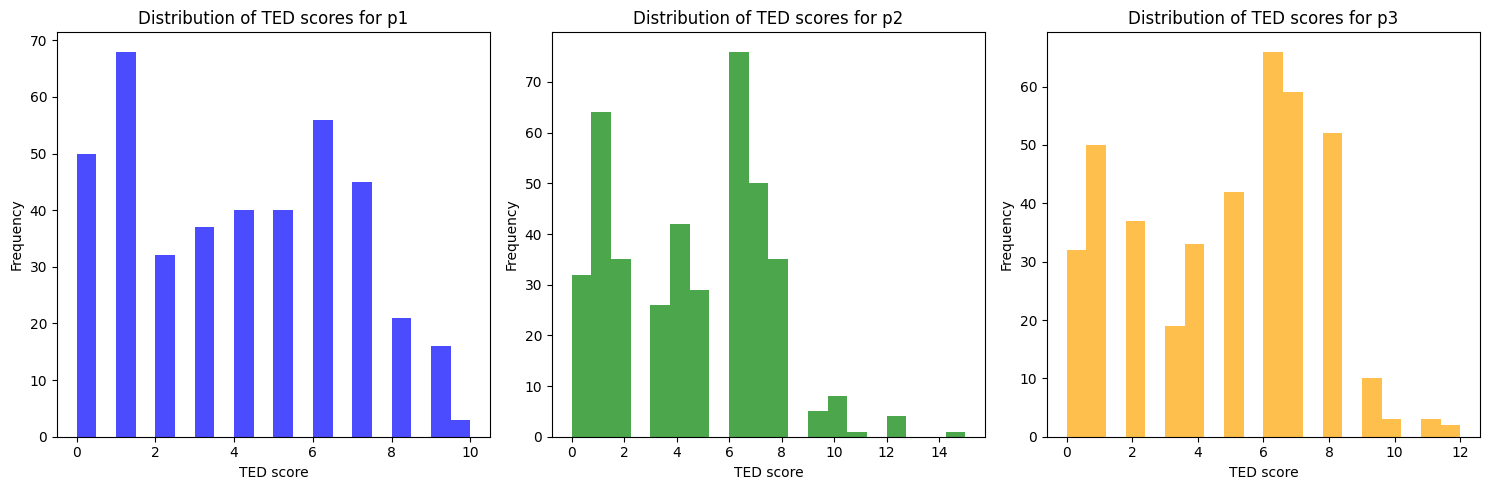

In [37]:
# We have already computed the TED scores and stored them in the df in p1_ted, p2_ted, and p3_ted columns
# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the distribution of TED scores for p1
axs[0].hist(concatenated_df['p1_ted'], bins=20, color='blue', alpha=0.7)
axs[0].set_title('Distribution of TED scores for p1')
axs[0].set_xlabel('TED score')
axs[0].set_ylabel('Frequency')

# Plot the distribution of TED scores for p2
axs[1].hist(concatenated_df['p2_ted'], bins=20, color='green', alpha=0.7)
axs[1].set_title('Distribution of TED scores for p2')
axs[1].set_xlabel('TED score')
axs[1].set_ylabel('Frequency')

# Plot the distribution of TED scores for p3
axs[2].hist(concatenated_df['p3_ted'], bins=20, color='orange', alpha=0.7)
axs[2].set_title('Distribution of TED scores for p3')
axs[2].set_xlabel('TED score')
axs[2].set_ylabel('Frequency')

plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/bootstrap_TED_distribution.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()


#### Plot over BERT scores

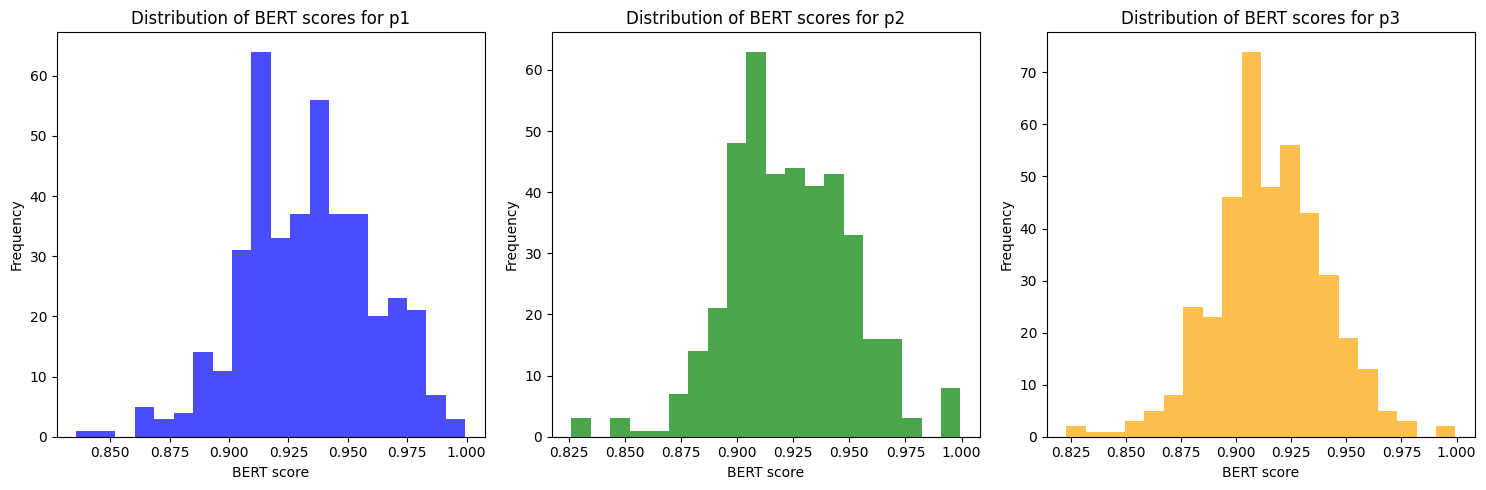

In [38]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the distribution of BERT scores for p1
axs[0].hist(concatenated_df['p1_bertscore'], bins=20, color='blue', alpha=0.7)
axs[0].set_title('Distribution of BERT scores for p1')
axs[0].set_xlabel('BERT score')
axs[0].set_ylabel('Frequency')

# Plot the distribution of BERT scores for p2
axs[1].hist(concatenated_df['p2_bertscore'], bins=20, color='green', alpha=0.7)
axs[1].set_title('Distribution of BERT scores for p2')
axs[1].set_xlabel('BERT score')
axs[1].set_ylabel('Frequency')

# Plot the distribution of BERT scores for p3
axs[2].hist(concatenated_df['p3_bertscore'], bins=20, color='orange', alpha=0.7)
axs[2].set_title('Distribution of BERT scores for p3')
axs[2].set_xlabel('BERT score')
axs[2].set_ylabel('Frequency')

plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/bootstrap_BERTscores_distribution.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()

In [40]:
# median judgment time for all workers and then per "paraphrase_0_notes"
p1_bertscore_median = concatenated_df["p1_bertscore"].median()
p1_bertscore_mean = concatenated_df["p1_bertscore"].mean()
print(f"p1_bertscore_mean: Median: {p1_bertscore_median:.4f}. Mean: {p1_bertscore_mean:.4f}.\n")

p1_bertscore_mean: Median: 0.9339. Mean: 0.9333.



In [41]:
concatenated_df.columns

Index(['input_utterance', 'intent', 'parameters', 'utterance_template',
       'source', 'seed_id', 'p1', 'p1_template', 'p2', 'p2_template', 'p3',
       'p3_template', 'p1_bertscore', 'p2_bertscore', 'p3_bertscore',
       'p1_duplicate', 'p1_semantics', 'p1_correct', 'p2_duplicate',
       'p2_semantics', 'p2_correct', 'p3_duplicate', 'p3_semantics',
       'p3_correct', 'p1_ted', 'p2_ted', 'p3_ted'],
      dtype='object')

### Plot syntaxtic distribution
Let's visualize the distribution of parse templates for the paraphrases of the first input utterance in the dataset.

In [46]:
def plot_paraphrase_syntax_distribution(df,path_to_plot_file):
    """
    Plot the distribution of paraphrase syntax templates and save the plot to a specified file path.

    :args
        df: The DataFrame containing the paraphrase data.
        path_to_plot_file: The path to save the plot file.
    """
    # Create a new column 'paraphrases_templates' by merging the values from 'p1_template', 'p2_template', and 'p3_template'
    paraphrases_templates_df = pd.concat([df['p1_template'], df['p2_template'], df['p3_template']], axis=0, ignore_index=True)

    # Rename the column to 'paraphrases_templates'
    paraphrases_templates_df.columns = ['paraphrases_templates']

    number_of_rows = paraphrases_templates_df.shape[0]

    # Plot the value counts as a horizontal bar chart
    ax = paraphrases_templates_df.value_counts().plot(
        kind="bar",
        title=f"Paraphrase Syntax Template Distribution Analysis - Exploring Syntax Patterns in {number_of_rows} Paraphrases",
        fontsize=2,
    )

    # Add subticks to the y-axis
    yticks_major = ax.get_yticks()
    yticks_minor = []
    for i in range(1, len(yticks_major)):
        yticks_minor.append((yticks_major[i] + yticks_major[i - 1]) / 2)
    ax.set_yticks(yticks_major, minor=False)
    ax.set_yticks(yticks_minor, minor=True)
    ax.yaxis.grid(True, which='minor', linestyle='--', linewidth=0.5)

    # Save the plot to the specified file path
    plt.savefig(path_to_plot_file, bbox_inches='tight')

    # Optionally, display the plot on the screen
    plt.show()

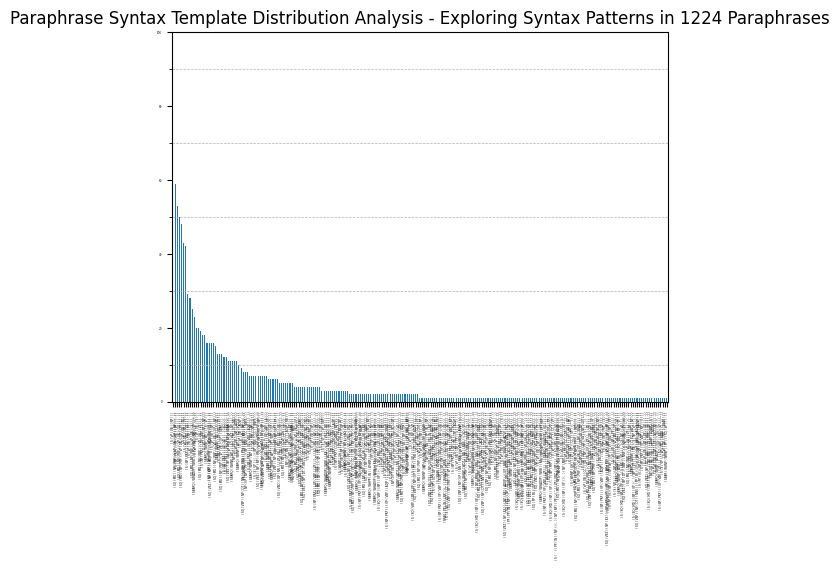

In [48]:
path_to_plot_file = f"{os.getcwd()}/plots/bootstrap_syntax_template_distribution.pdf"
plot_paraphrase_syntax_distribution(concatenated_df,path_to_plot_file)

##### Plot syntax distribution for a pX_template columns
To plot the distribution of syntax templates for a specific column, such as 'p1_template', you can follow these steps:
1. Select the column from the DataFrame.
2. Use the value_counts() method to count the occurrences of each syntax template.
3. Plot the distribution using a bar chart.

( S ( VP ( VB ) ( NP ) ) )                                                                  33
( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ) ( . ) )                                     30
( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ( NP ) ) ( . ) )                              26
( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ( PP ) ) ( . ) )                              19
( S ( VP ( VB ) ( PP ) ) )                                                                  18
                                                                                            ..
( S ( NP ( UH ) ) ( VP ( VB ) ( NP ) ) ( . ) )                                               1
( S ( S ( VP ) ) ( VP ( VBP ) ) )                                                            1
( S ( VP ( VB ) ( NP ) ( NP ) ( PP ) ) )                                                     1
( SQ ( VBZ ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ) ( . ) )                                      1
( S ( SQ ( MD ) ( NP ) ( VP ) ) ( . ) ( NP ( PRP )

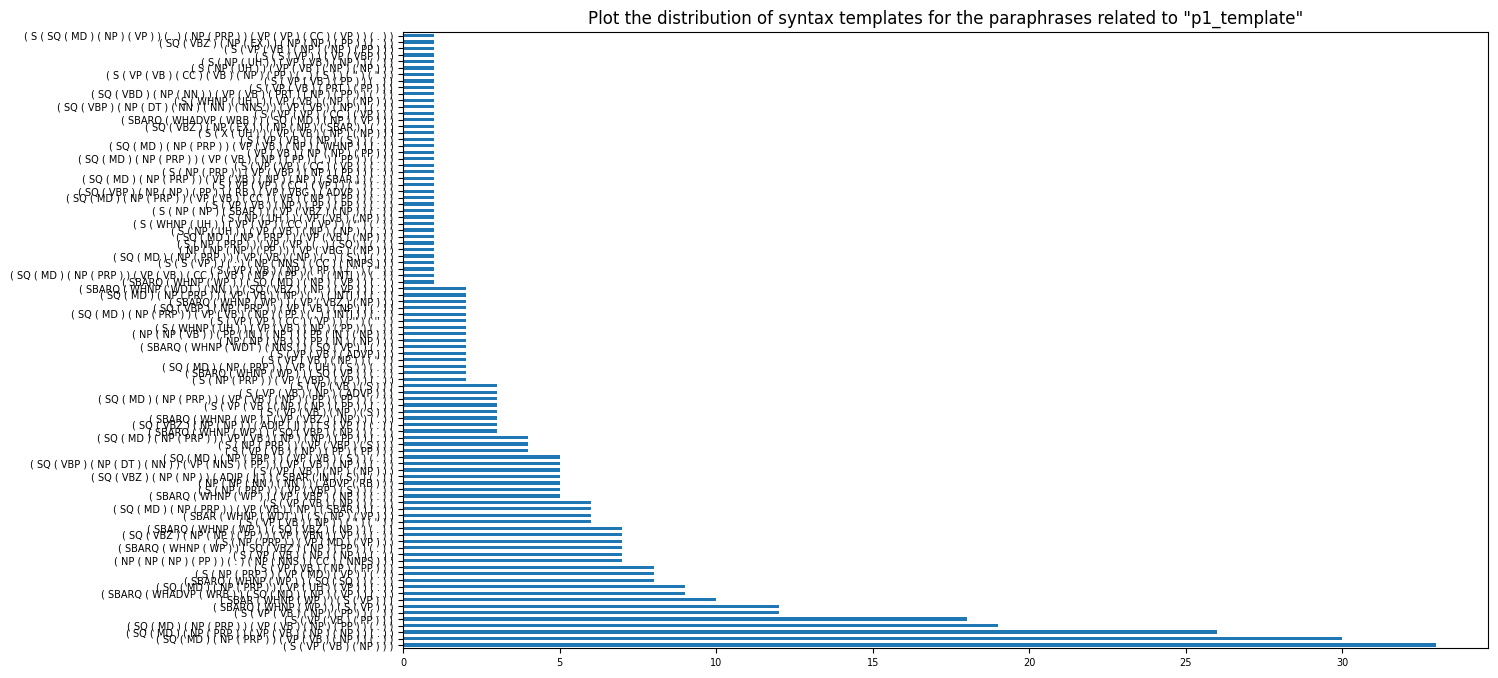

In [55]:
# Select a syntax template column between: p1_template p2_template or p3_template
selected_column = 'p1_template'
concatenated_df.p1_template.value_counts().plot(
    kind="barh",
    figsize=(14,8),
    fontsize=7,
    title=f"Plot the distribution of syntax templates for the paraphrases related to \"{selected_column}\""
)
concatenated_df.p1_template.value_counts()#count how many unique templates in p1_parse_template
# df.input_utterance.value_counts()#count how many utterance in df

##### Calculate the count of distinct syntax templates.
This process involves determining the total count of unique syntax templates present within the generated paraphrases.

In [66]:
paraphrases_templates_df = pd.concat(
    [concatenated_df['p1_template'], concatenated_df['p2_template'], concatenated_df['p3_template']], axis=0, ignore_index=True
)

print(f"There are a total of {paraphrases_templates_df.unique().shape[0]} distinct syntax templates present.")

There are a total of 233 distinct syntax templates present.


### Compute metrics
To analyze the quality of paraphrases, we will calculate three metrics: DIV, TTR, and mean PINC scores.
1. `Step 1 - Data Preparation`:

   First, we will extract all correct p1, p2, and p3 paraphrases and merge the values from these three columns into a single column called "paraphrase_value." This will result in a new DataFrame with two columns: 'input_utterance' and 'paraphrase_value'.
2. `Metric Calculation`:

   Next, we will compute the DIV, TTR, and mean PINC scores for the paraphrases in the "paraphrase_value" column. These metrics will provide valuable insights into the diversity, lexical richness, and fluency of the generated paraphrases.

#### Step 1 - Data preparation

In [78]:
concatenated_df.columns

Index(['input_utterance', 'intent', 'parameters', 'utterance_template',
       'source', 'seed_id', 'p1', 'p1_template', 'p2', 'p2_template', 'p3',
       'p3_template', 'p1_bertscore', 'p2_bertscore', 'p3_bertscore',
       'p1_duplicate', 'p1_semantics', 'p1_correct', 'p2_duplicate',
       'p2_semantics', 'p2_correct', 'p3_duplicate', 'p3_semantics',
       'p3_correct', 'p1_ted', 'p2_ted', 'p3_ted'],
      dtype='object')

In [79]:
def extract_combined_series(df):
    """
    Extracts a combined series of correct paraphrase templates and values from the concatenated DataFrame.

    :args
        df: The concatenated DataFrame containing paraphrase data.
    :return
        A combined series with correct paraphrase templates and values.
    """
    # Extract the syntax templates of incorrect p1 paraphrases
    correct_p1_template = df.loc[df['p1_correct'], ['input_utterance', 'p1', 'p1_template']]
    correct_p1_template.rename(columns={'p1': 'paraphrase_value'}, inplace=True)
    correct_p1_template.rename(columns={'p1_template': 'paraphrase_template'}, inplace=True)

    # Extract the syntax templates of incorrect p2 paraphrases
    correct_p2_template = df.loc[df['p2_correct'], ['input_utterance', 'p2', 'p2_template']]
    correct_p2_template.rename(columns={'p2': 'paraphrase_value'}, inplace=True)
    correct_p2_template.rename(columns={'p2_template': 'paraphrase_template'}, inplace=True)
    
    # Extract the syntax templates of incorrect p3 paraphrases
    correct_p3_template = df.loc[df['p3_correct'], ['input_utterance', 'p3', 'p3_template']]
    correct_p3_template.rename(columns={'p3': 'paraphrase_value'}, inplace=True)
    correct_p3_template.rename(columns={'p3_template': 'paraphrase_template'}, inplace=True)

    combined_series = pd.concat([correct_p1_template, correct_p2_template, correct_p3_template], ignore_index=True)
    return combined_series

In [69]:
combined_series = extract_combined_series(concatenated_df)
combined_series

,input_utterance,paraphrase_value,paraphrase_template
0,Terminate i-a541 now,End i-a541 immediately,( NP ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) )
1,Search for cooking videos,Find videos on how to cook,( S ( VP ( VB ) ( NP ) ) )
2,Find most popular photos tagged #LOVE,Discover the trending pictures labeled #LOVE,( S ( S ( VP ) ) ( VP ( VBP ) ) )
3,Search for a few nice photos matching Opera Ho...,Find some beautiful pictures that match Opera ...,( S ( VP ( VB ) ( NP ) ) ( . ) )
4,Are the burglar alarms in the office malfuncti...,Do the burglar alarms in the office have a mal...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ) ( VP ( NNS )...
...,...,...,...
1183,can i get a rental car in dallas,is there a way for me to get a rental car in d...,( SQ ( VBZ ) ( NP ( EX ) ) ( NP ( NP ) ( SBAR ...
1184,what airlines fly between boston and atlanta,can you tell me what airlines provide service ...,( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ...
1185,show me the airlines between boston and denver,show me the flights available between Boston a...,( S ( VP ( VB ) ( S ) ) )
1186,what does ls stand for,provide me with the expansion of ls,( S ( VP ( VB ) ( NP ) ( PP ) ) )


#### Step 2 - Compute metrics

In [70]:
def compute_metrics(df, input_utterance):
    df_s = df[df["input_utterance"] == input_utterance]
    paraphrases = df_s["paraphrase_value"].values
    ttr_metric = metrics.compute_ttr(input_utterance, paraphrases)
    pincs = [metrics.compute_pinc(input_utterance, p) for p in paraphrases]
    mean_pinc = sum(pincs) / len(pincs)
    div = metrics.compute_div({input_utterance: paraphrases})
    return ttr_metric["ttr"], mean_pinc, div

ttrs = []
mean_pincs = []
divs = []
# df_correct = df[df.is_correct == 1]

for iu in combined_series["input_utterance"].unique():
    ttr, mean_pinc, div = compute_metrics(combined_series,iu)
    ttrs.append(ttr)
    mean_pincs.append(mean_pinc)
    divs.append(div)

ttrs = np.array(ttrs)
mean_pincs = np.array(mean_pincs)
divs = np.array(divs)
print(f"\nMean TTR: {ttrs.mean():.4f} \nMean PINC: {mean_pincs.mean():.4f} \nDIV: {divs.mean():.4f}")


Mean TTR: 0.1539 
Mean PINC: 0.4484 
DIV: 0.7457


# Pattern Distribution Plot
Analyzing Patterns in Correct Paraphrases for 50 Seed Utterances. The plot showcases the frequency distribution of paraphrase patterns, specifically focusing on the correct paraphrases. After selecting the correct paraphrases, 50 Seed Utterances remain for analysis.

In [72]:
def plot_and_save_pattern_distribution(df, output_path, width=16, height=10, min_ncols=8, iu_column="input_utterance"):
    ncols = min(min_ncols, df[iu_column].value_counts().shape[0])
    nrows = math.ceil(df[iu_column].value_counts().shape[0] / ncols)
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_figwidth(width)
    fig.set_figheight(height)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.suptitle("Overall Pattern Distribution", fontsize=16)
    
    row = 0
    col = 0

    # Define a color palette for the patterns
    pattern_colors = sns.color_palette("Set1", n_colors=3)
    
    for _, input_utterance in enumerate(df[iu_column].value_counts().index.values):
        df_data = df[df[iu_column] == input_utterance]
        ax = axes[row][col] if nrows > 1 else axes[col]
        g = sns.countplot(
            x="paraphrase_template",
            data=df_data,
            order=df_data.paraphrase_template.value_counts().sort_values().index,
            ax=ax,
            palette=pattern_colors
        )
        g.set(xlabel="patterns")
        g.set(xticklabels=[])
        col += 1
        
        if col == ncols:
            col = 0
            row += 1
    
    if output_path:
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

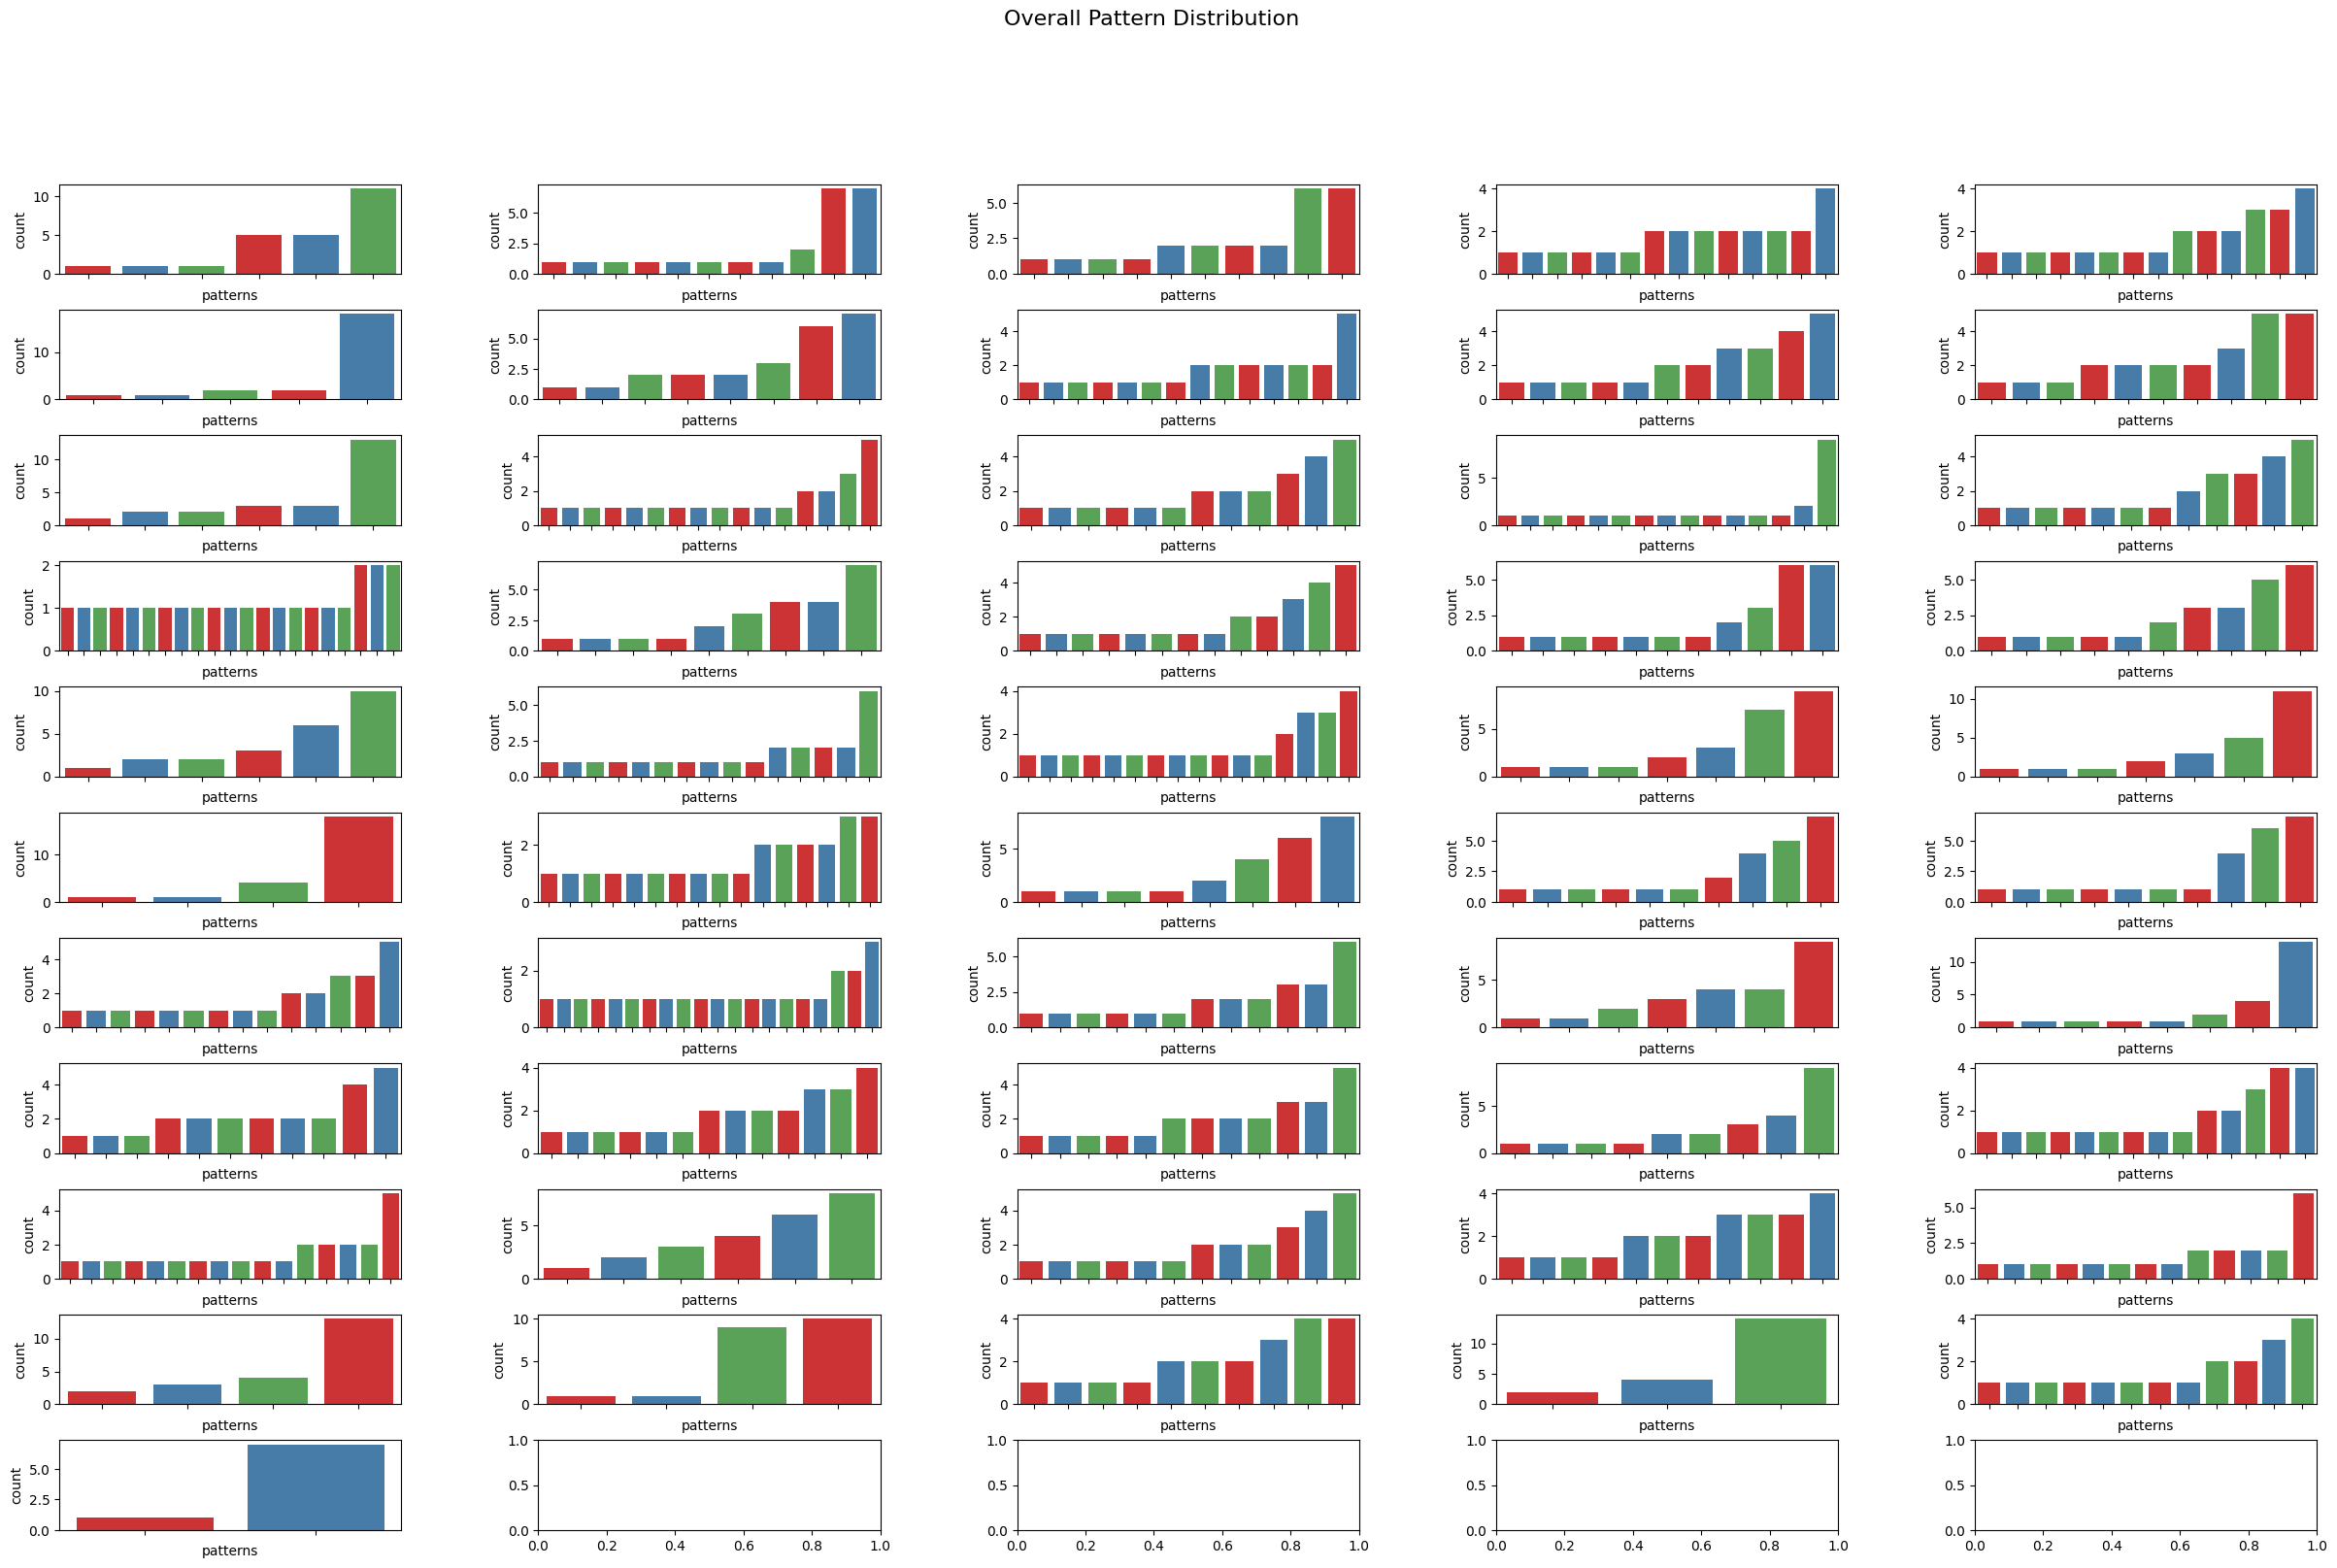

In [74]:
output_path = f"{os.getcwd()}/plots/bootstrap-pattern-distribution.pdf"
plot_and_save_pattern_distribution(combined_series, output_path, width=30, height=18, min_ncols=5)

In [75]:
combined_series.paraphrase_template.unique().shape

(230,)

In [76]:
output_file = f"{os.getcwd()}/output/bootstrap_round/bootstrap-combined_series.csv"
combined_series.to_csv(output_file, index=False)
combined_series.head()

,input_utterance,paraphrase_value,paraphrase_template
0,Terminate i-a541 now,End i-a541 immediately,( NP ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) )
1,Search for cooking videos,Find videos on how to cook,( S ( VP ( VB ) ( NP ) ) )
2,Find most popular photos tagged #LOVE,Discover the trending pictures labeled #LOVE,( S ( S ( VP ) ) ( VP ( VBP ) ) )
3,Search for a few nice photos matching Opera Ho...,Find some beautiful pictures that match Opera ...,( S ( VP ( VB ) ( NP ) ) ( . ) )
4,Are the burglar alarms in the office malfuncti...,Do the burglar alarms in the office have a mal...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ) ( VP ( NNS )...


### random selection and comparison of Syn templates

In [94]:
def plot_and_save_pattern_distribution(df, output_path, width=16, height=10, min_ncols=8, iu_column="input_utterance"):

    random_selected_syn = [
        'Search for cooking videos',
        'What is the forecast for Harrison-Crawford State Forest',
        'Are there any cheap hotels for 7-day stay somewhere near Riverside',
        'Search for a few nice photos matching Opera House with size 1024px * 768px',
        "I want reviews for McDonald's at Kensington st.",
        'Rate this album two out of 6',
        'what is the lowest fare from denver to pittsburgh',
        'Book a table for eight people please',
        'Is the TV in the house off ?',
        'please give me the cheapest flight from denver to pittsburgh'
    ]
    
    ncols = min(min_ncols, df[iu_column].value_counts().shape[0])
    nrows = math.ceil(df[iu_column].value_counts().shape[0] / ncols)
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_figwidth(width)
    fig.set_figheight(height)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.suptitle("Overall Pattern Distribution", fontsize=16)
    
    row = 0
    col = 0

    # Define a color palette for the patterns
    pattern_colors = sns.color_palette("Set1", n_colors=3)
    
    for _, input_utterance in enumerate(df[iu_column].value_counts().index.values):
        if input_utterance in random_selected_syn:
            df_data = df[df[iu_column] == input_utterance]
            ax = axes[row][col] if nrows > 1 else axes[col]
            g = sns.countplot(
                x="paraphrase_template",
                data=df_data,
                order=df_data.paraphrase_template.value_counts().sort_values().index,
                ax=ax,
                palette=pattern_colors
            )
            g.set(xlabel="patterns")
            ax.set(xlabel=None)
            g.set(xticklabels=[])
            g.set_title(f"{input_utterance}",fontdict= { 'fontsize': 8, 'fontweight':'bold'}, y =1.1)
            col += 1
            
            if col == ncols:
                col = 0
                row += 1
    
    if output_path:
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.subplots_adjust(hspace = 0.6)
    plt.show()
    plt.close(fig)

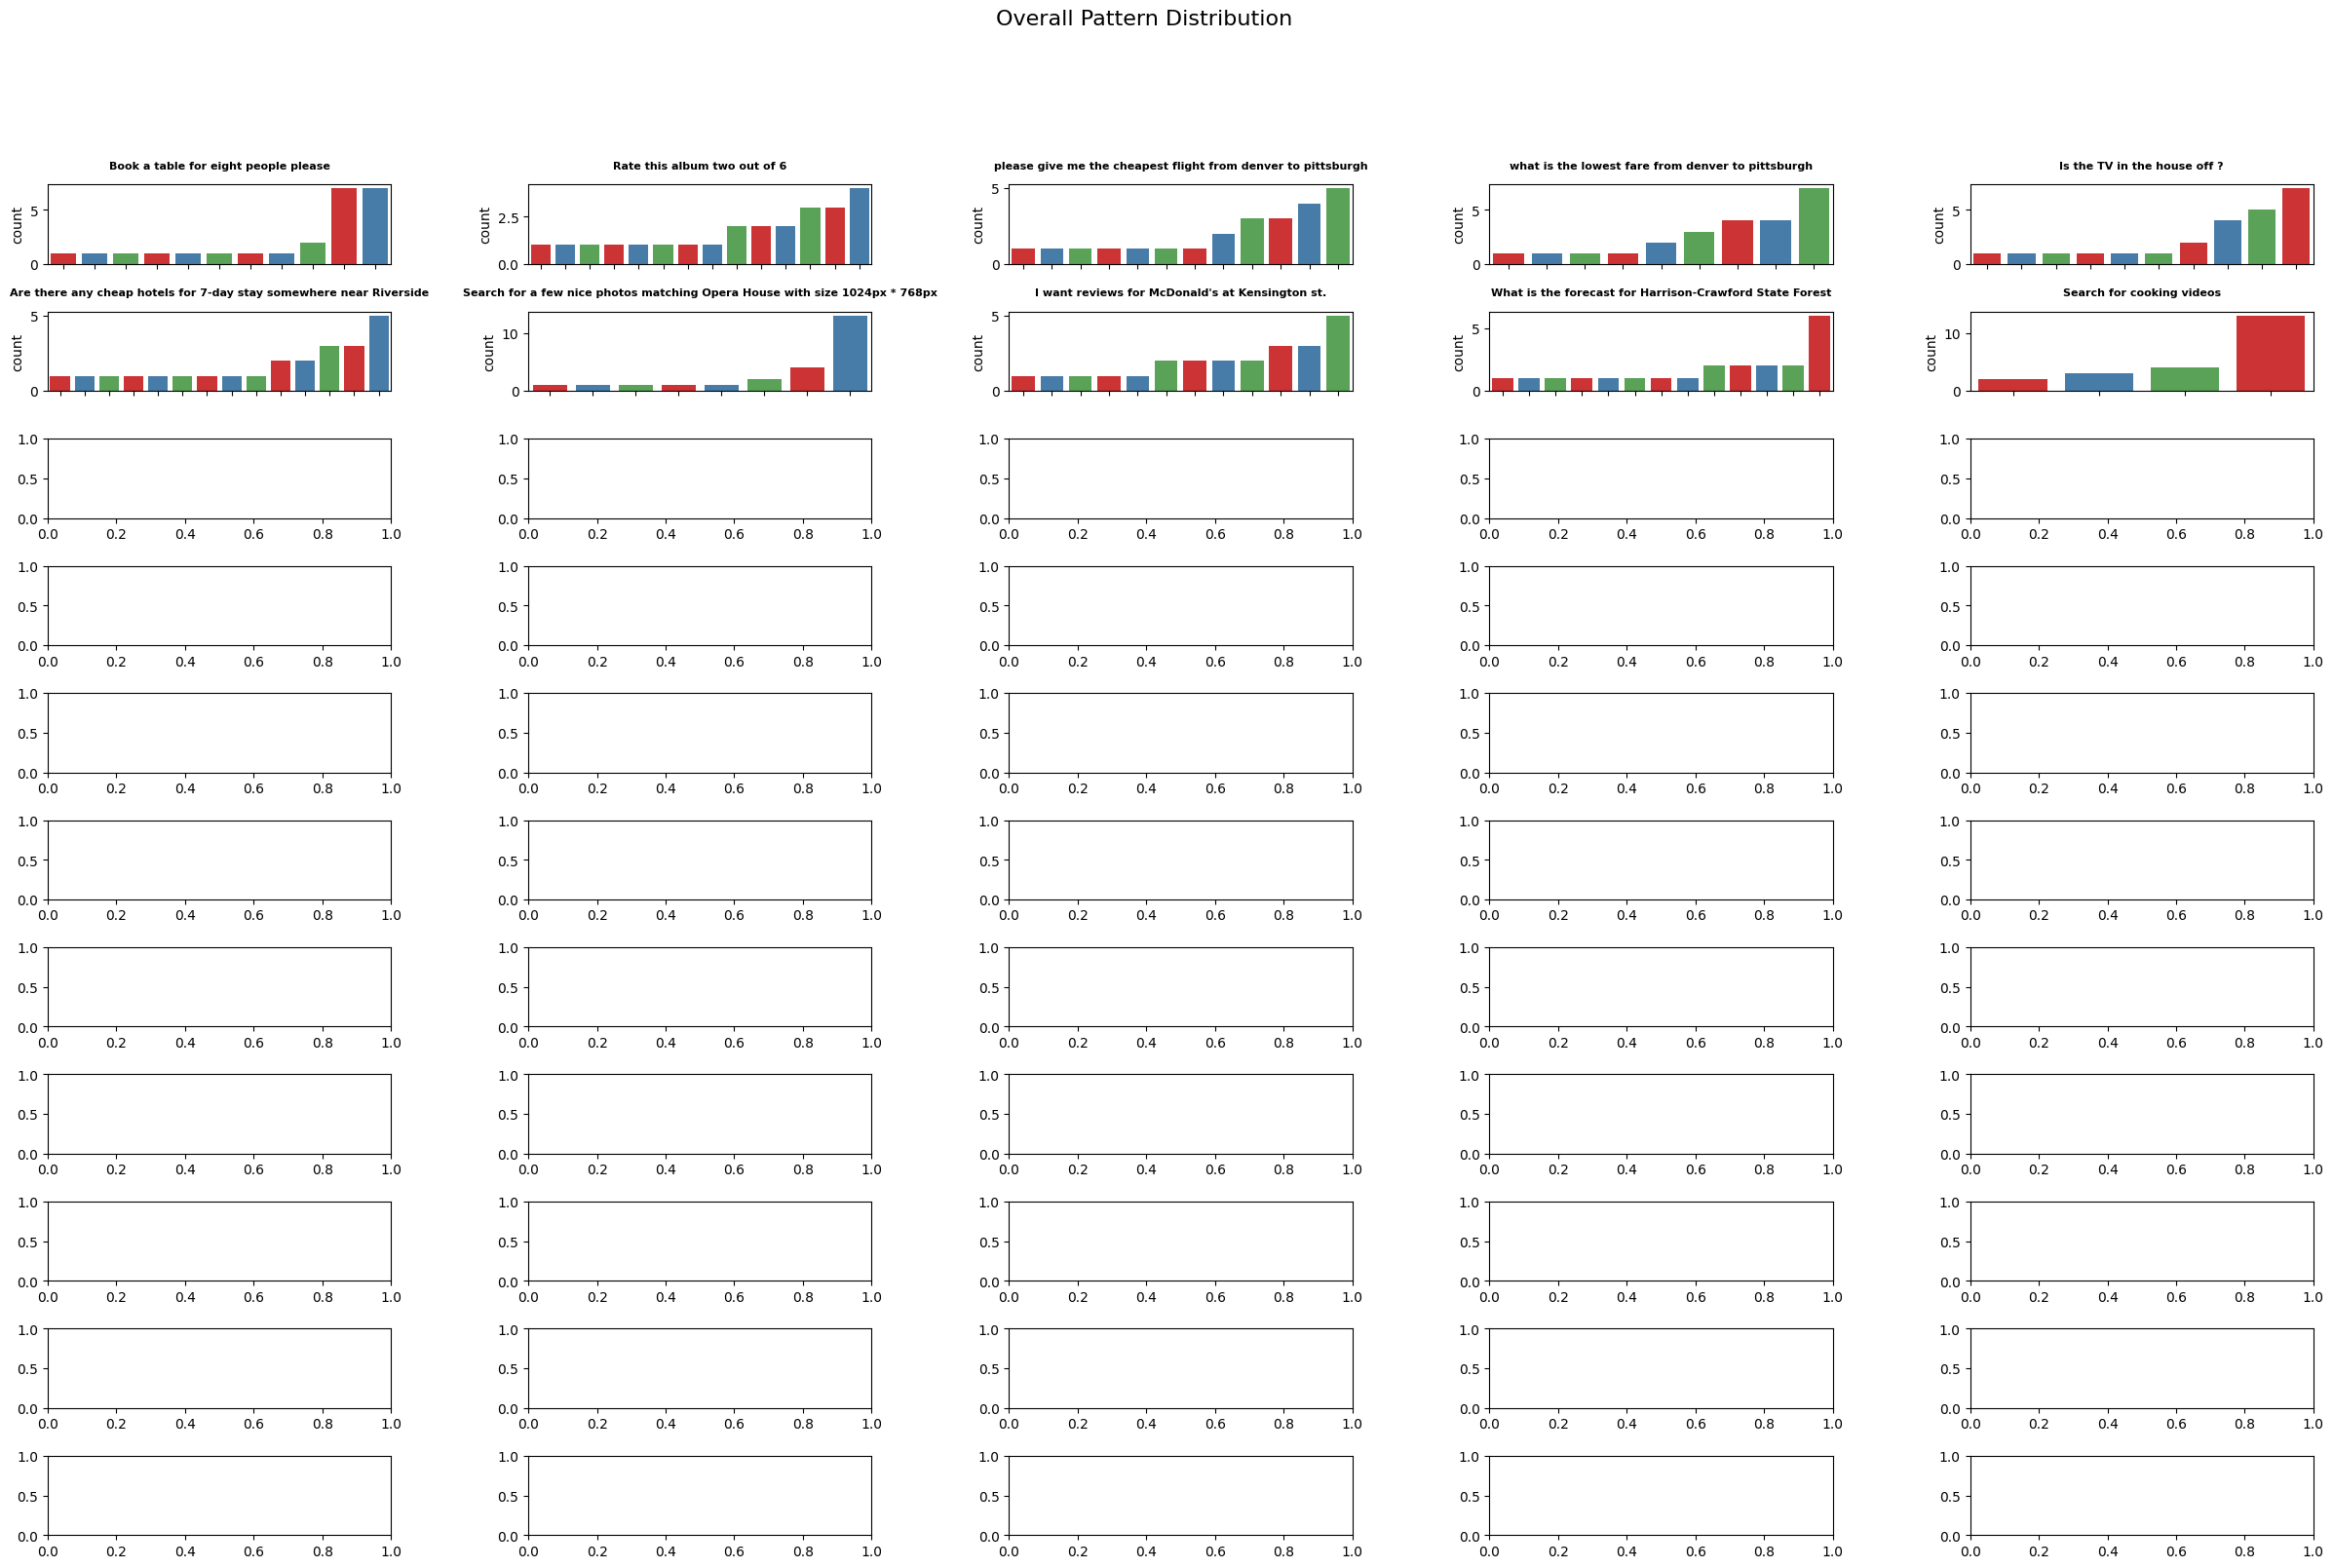

In [95]:
output_path = f"{os.getcwd()}/plots/bootstrap-pattern-distribution-random.pdf"
plot_and_save_pattern_distribution(combined_series, output_path, width=30, height=18, min_ncols=5)

#### TED mean and median

### Calculate the individual mean and median scores for each paraphrase column.
Instead of combining the scores for p1_ted, p2_ted, and p3_ted, compute their mean and median separately. This approach facilitates a nuanced comparison of paraphrases based on their generation position. For instance, p1 corresponds to the first paraphrase generated, p2 to the second, and so forth. This distinct analysis provides insights into the quality and variation of paraphrases across different stages of generation.

In [77]:
# concatenated_df
combined_series.columns

Index(['input_utterance', 'paraphrase_value', 'paraphrase_template'], dtype='object')

In [80]:
# median for all correct paraphrases generated at position 1 'p1'
p1_ted_median = concatenated_df["p1_ted"].median()
p1_ted_mean = concatenated_df["p1_ted"].mean()
print(f"p1_ted: Median: {p1_ted_median:.4f}. Mean: {p1_ted_mean:.4f}.\n")

# median for all correct paraphrases generated at position 2 'p2'
p2_ted_median = concatenated_df["p2_ted"].median()
p2_ted_mean = concatenated_df["p2_ted"].mean()
print(f"p2_ted: Median: {p2_ted_median:.4f}. Mean: {p2_ted_mean:.4f}.\n")

# median for all correct paraphrases generated at position 3 'p3'
p3_ted_median = concatenated_df["p3_ted"].median()
p3_ted_mean = concatenated_df["p3_ted"].mean()
print(f"p3_ted: Median: {p3_ted_median:.4f}. Mean: {p3_ted_mean:.4f}.\n")

p1_ted: Median: 4.0000. Mean: 3.9118.

p2_ted: Median: 5.0000. Mean: 4.4363.

p3_ted: Median: 5.0000. Mean: 4.7181.



#### Calculating the Mean and Median for the Complete Paraphrase TED Score List
In this step, we consolidate all the Tree Edit Distance (TED) scores associated with the paraphrases into a single comprehensive list. Subsequently, we calculate both the mean and median values for this aggregated TED score list. This approach allows us to gain a holistic understanding of the overall syntactic diversity exhibited by the paraphrases.

In [82]:
# Extract 'p1_ted'
p1_ted = concatenated_df.loc[concatenated_df['p1_correct'], 'p1_ted']

# Extract 'p2_ted'
p2_ted = concatenated_df.loc[concatenated_df['p2_correct'], 'p2_ted']

# Extract 'p3_ted'
p3_ted = concatenated_df.loc[concatenated_df['p3_correct'], 'p3_ted']

# Concatenate them into one new series called combined_series
combined_ted_scores = pd.DataFrame()
combined_ted_scores = pd.concat([p1_ted, p2_ted, p3_ted], ignore_index=True)


paraphrases_ted_median = combined_ted_scores.median()
paraphrases_ted_mean = combined_ted_scores.mean()
print(f"Paraphrases Tree Edit Distance: Median: Median: {paraphrases_ted_median:.4f}. Mean: {paraphrases_ted_mean:.4f}.\n")
combined_ted_scores.shape

Paraphrases Tree Edit Distance: Median: Median: 5.0000. Mean: 4.3746.



(1188,)

## BERTscore mean and median

#### Calculate the individual mean and median scores for each paraphrase column.
Instead of combining the scores for p1_bertscore, p2_bertscore, and p3_bertscore, compute their mean and median separately. This approach facilitates a nuanced comparison of paraphrases based on their generation position. For instance, p1 corresponds to the first paraphrase generated, p2 to the second, and so forth. This distinct analysis provides insights into the quality and variation of paraphrases across different stages of generation.

In [83]:
# BERTscores for p1
p1_bertscore_median = concatenated_df["p1_bertscore"].median()
p1_bertscore_mean = concatenated_df["p1_bertscore"].mean()
print(f"BERT scores: Median: {p1_bertscore_median:.4f}. Mean: {p1_bertscore_mean:.4f}.\n")

# BERTscores for p2
p2_bertscore_median = concatenated_df["p2_bertscore"].median()
p2_bertscore_mean = concatenated_df["p2_bertscore"].mean()
print(f"BERT scores: Median: {p2_bertscore_median:.4f}. Mean: {p2_bertscore_mean:.4f}.\n")

# BERTscores p3
p3_bertscore_median = concatenated_df["p3_bertscore"].median()
p3_bertscore_mean = concatenated_df["p3_bertscore"].mean()
print(f"BERT scores: Median: {p3_bertscore_median:.4f}. Mean: {p3_bertscore_mean:.4f}.\n")

BERT scores: Median: 0.9339. Mean: 0.9333.

BERT scores: Median: 0.9215. Mean: 0.9231.

BERT scores: Median: 0.9154. Mean: 0.9154.



#### Calculating the Mean and Median for the Complete Paraphrase BERT Score List
In this step, we aggregate all the BERT scores associated with the paraphrases into a single comprehensive list. Subsequently, we compute both the mean and median values for this aggregated BERT score list. This approach enables us to comprehensively assess the overall quality and effectiveness of the paraphrases in terms of their semantic similarity to the input utterance.

In [84]:
# median
# combined_bertscores_df = df[(df['p1_correct'] == True) | (df['p2_correct'] == True) | (df['p3_correct'] == True)][['INPUT:input_utterance','p1_correct','p2_correct','p3_correct','p1_bertscore', 'p2_bertscore', 'p3_bertscore']]

# Extract 'p1_bertscore'
p1_bertscore = concatenated_df.loc[concatenated_df['p1_correct'], 'p1_bertscore']

# Extract 'p2_bertscore'
p2_bertscore = concatenated_df.loc[concatenated_df['p2_correct'], 'p2_bertscore']

# Extract 'p3_bertscore'
p3_bertscore = concatenated_df.loc[concatenated_df['p3_correct'], 'p3_bertscore']

# Concatenate them into one new series called combined_series
combined_bertscores = pd.concat([p1_bertscore, p2_bertscore, p3_bertscore], ignore_index=True)
combined_bertscores


paraphrases_bertscores_median = combined_bertscores.median()
paraphrases_bertscores_mean = combined_bertscores.mean()
print(f"paraphrases_bertscores: Median: {paraphrases_bertscores_median:.4f}. Mean: {paraphrases_bertscores_mean:.4f}.\n")
combined_bertscores.shape

paraphrases_bertscores: Median: 0.9211. Mean: 0.9220.



(1188,)

## Save a cleaned DataFrame.
Consolidate the columns like 'p1_ted', 'p2_ted', and 'p3_ted' into a single column named 'ted'.

In [93]:
def extract_combined_series(df):
    """
    Extracts a combined series of correct paraphrase templates and values from the concatenated DataFrame.

    :args
        df: The concatenated DataFrame containing paraphrase data.
    :return
        A combined series with correct paraphrase templates and additional columns.
    """
    # Columns to extract
    columns_to_extract = ['input_utterance', 'intent', 'parameters', 'utterance_template','source', 'seed_id']

    # Extract the specified columns along with the paraphrase templates and values
    correct_p1_template = df.loc[df['p1_correct'], columns_to_extract+['p1', 'p1_template','p1_bertscore','p1_ted']]
    correct_p1_template.rename(
        columns={
            'p1': 'paraphrase_value',
            'p1_template': 'paraphrase_template',
            'p1_bertscore': 'bertscore',
            'p1_ted': 'ted',
        }, inplace=True
    )

    correct_p2_template = df.loc[df['p2_correct'], columns_to_extract+['p2', 'p2_template','p2_bertscore','p2_ted']]
    correct_p2_template.rename(
        columns={
            'p2': 'paraphrase_value',
            'p2_template': 'paraphrase_template',
            'p2_bertscore': 'bertscore',
            'p2_ted': 'ted',
        }, inplace=True
    )

    correct_p3_template = df.loc[df['p3_correct'], columns_to_extract+['p3', 'p3_template','p3_bertscore','p3_ted']]
    correct_p3_template.rename(
        columns={
            'p3': 'paraphrase_value',
            'p3_template': 'paraphrase_template',
            'p3_bertscore': 'bertscore',
            'p3_ted': 'ted',
        }, inplace=True
    )

    combined_series = pd.concat([correct_p1_template, correct_p2_template, correct_p3_template], ignore_index=True)
    return combined_series

In [94]:
bootstrap_df = extract_combined_series(concatenated_df)
print(bootstrap_df.shape)
bootstrap_df.columns

(1188, 10)


Index(['input_utterance', 'intent', 'parameters', 'utterance_template',
       'source', 'seed_id', 'paraphrase_value', 'paraphrase_template',
       'bertscore', 'ted'],
      dtype='object')

In [95]:
output_file = f"{os.getcwd()}/output/bootstrap_round/bootstrap-clean.csv"
duplicates_data.append({"seed_utterance": "Total", "num_duplicates": sum(d["num_duplicates"] for d in duplicates_data)})

#### <div style="background-color: lightblue; padding: 10px;">Visualize the Distribution of TED Scores for all Paraphrases</div>

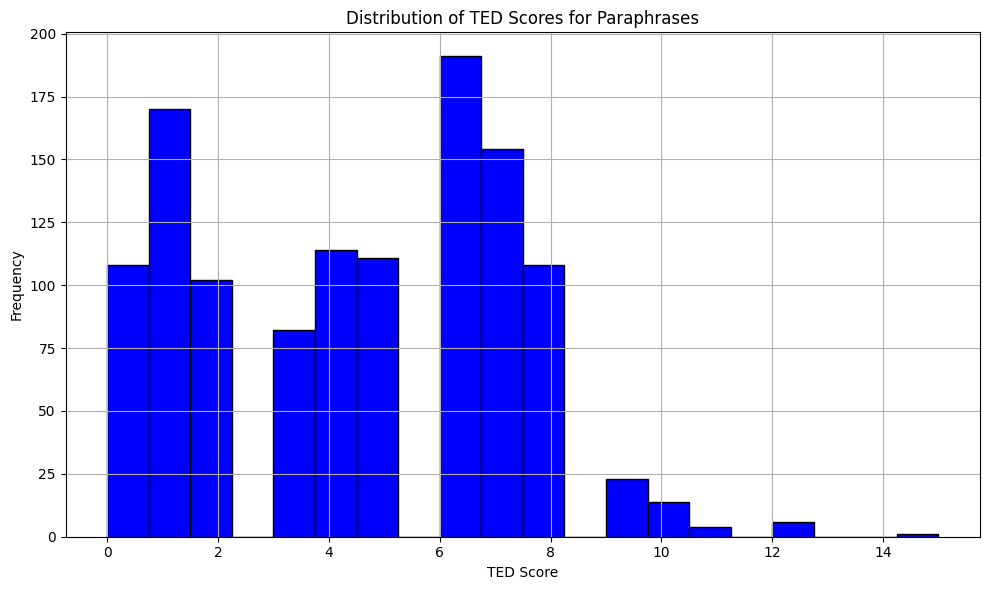

In [96]:
# Create a figure with subplots
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_df['ted'], bins=20, color='blue', edgecolor='black')
plt.xlabel('TED Score')
plt.ylabel('Frequency')
plt.title('Distribution of TED Scores for Paraphrases')
plt.grid(True)
plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/bootstrap_TED_distribution_all.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()

#### <div style="background-color: lightgreen; padding: 10px;">Visualize the Distribution of BERT Scores for all Paraphrases</div>

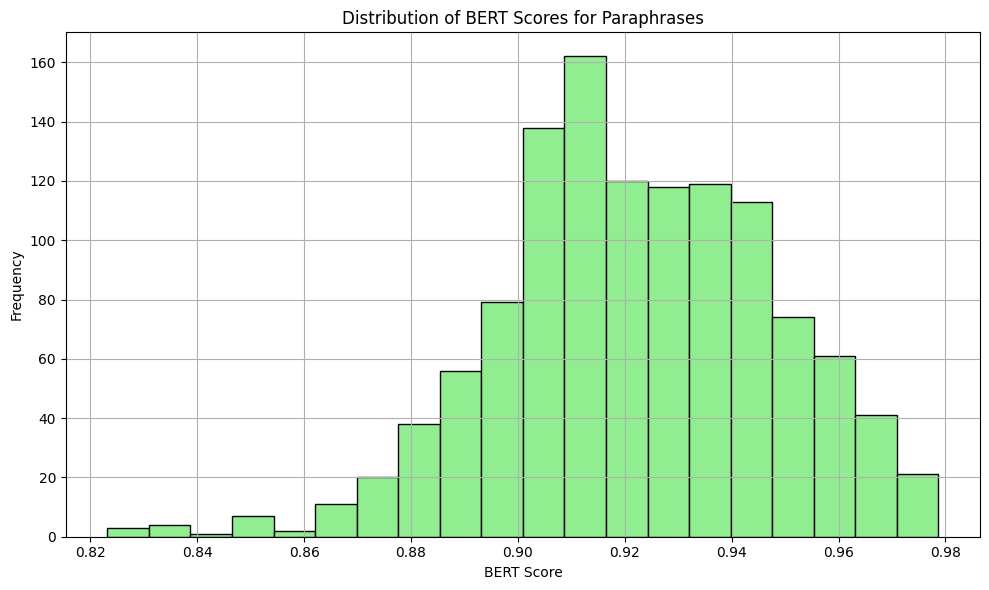

In [99]:
# Create a figure with subplots
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_df['bertscore'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('BERT Score')
plt.ylabel('Frequency')
plt.title('Distribution of BERT Scores for Paraphrases')
plt.grid(True)
plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/bootstrap_BERT_distribution_all.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()

#### <div style="background-color: lightblue; padding: 10px;">Visualize the Distribution of Syntax tenplates for correct Paraphrases</div>

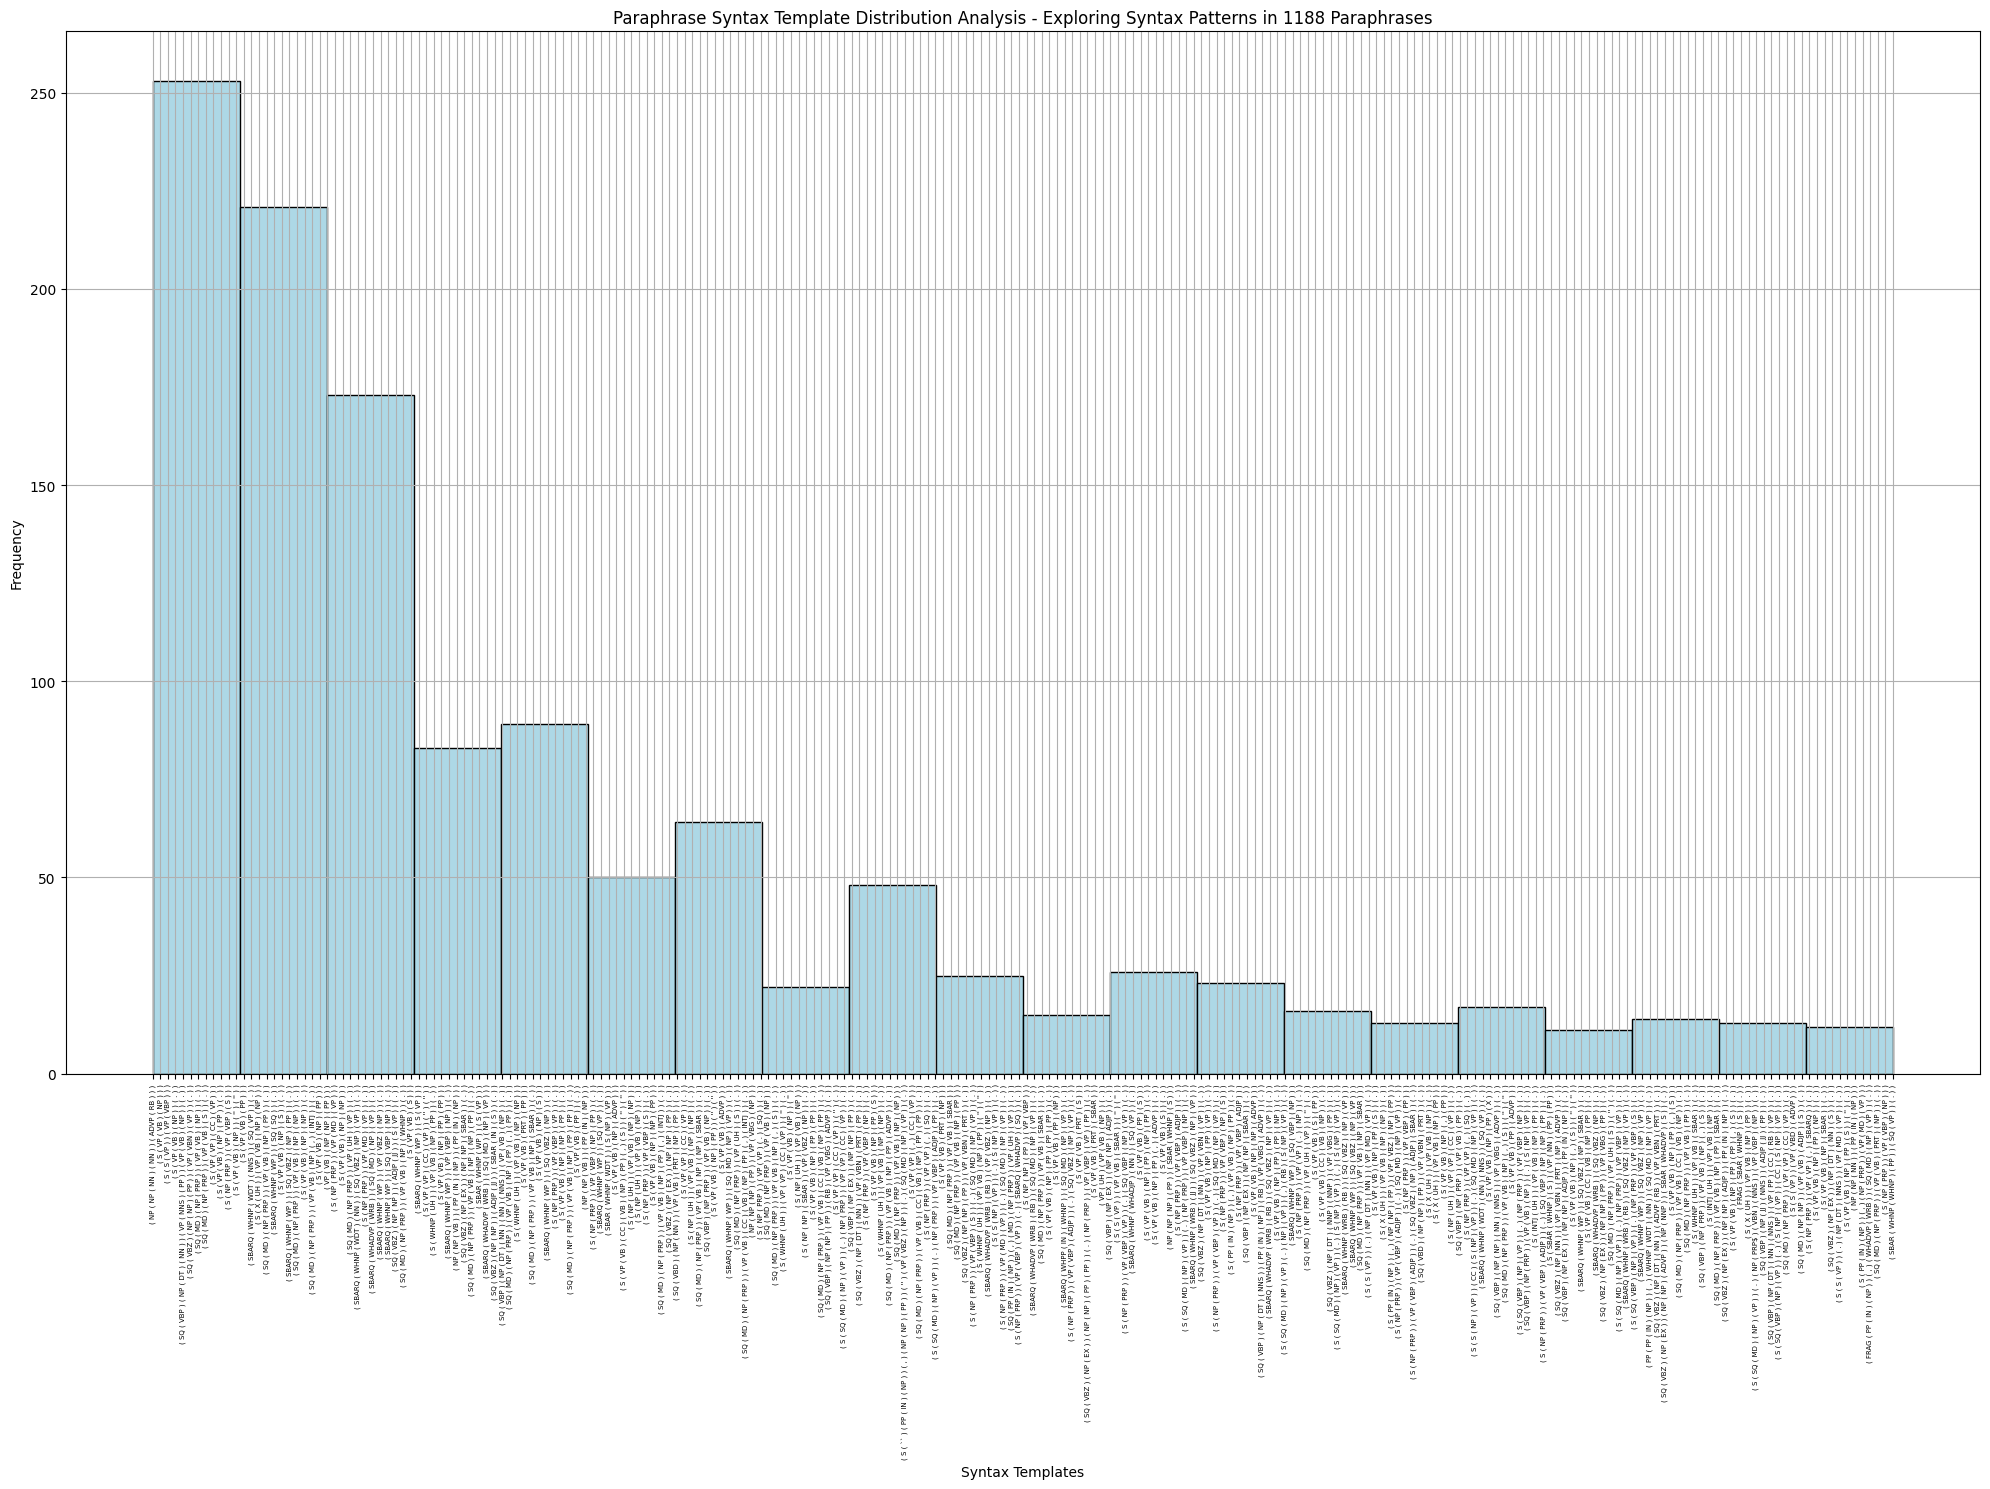

In [120]:
# Create a figure with subplots
number_of_rows = bootstrap_df.shape[0]
title= f"Paraphrase Syntax Template Distribution Analysis - Exploring Syntax Patterns in {number_of_rows} Paraphrases"
plt.figure(figsize=(20, 15))
plt.hist(bootstrap_df['paraphrase_template'], bins=20, color='lightblue', edgecolor='black')
plt.xlabel('Syntax Templates')
plt.ylabel('Frequency')
plt.title(title)
plt.xticks(rotation='vertical', fontsize=5)
plt.grid(True)
plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/bootstrap_paraphrase_template_distribution_all.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()

In [126]:
print(bootstrap_df.shape)
bootstrap_df.paraphrase_template.unique().shape

(1188, 10)


(230,)

##### <div style="background-color: lightblue; padding: 10px; display: inline-block;">Initial statistical overview before starting the workflow.</div>

In [142]:
p_candidates = bootstrap_df.paraphrase_value.to_list()
unique_p_candidates = set(p_candidates)
num_duplicates = len(p_candidates) - len(unique_p_candidates)

print(
    "Count of recurring paraphrases, i.e., instances where paraphrases were repeatedly generated by GPT, resulting in duplicates "\
    f"among the paraphrase set. For a list of {len(p_candidates)} paraphrases generated {num_duplicates} are duplicates."
    ""
)

Count of recurring paraphrases, i.e., instances where paraphrases were repeatedly generated by GPT, resulting in duplicates among the paraphrase set. For a list of 1188 paraphrases generated 146 are duplicates.


##### <div style="background-color: lightblue; padding: 10px; display: inline-block;">Statistical overview per seed utterance.</div>
Count the number of duplicates paraphrases for each seed utterance.

In [159]:
duplicates_data = []

for utr in bootstrap_df["input_utterance"].unique():
    df_row = bootstrap_df[bootstrap_df["input_utterance"] == utr]
    p_candidates = df_row.paraphrase_value.to_list()
    unique_p_candidates = set(p_candidates)
    num_duplicates = len(p_candidates) - len(unique_p_candidates)
    duplicates_data.append({"input_utterance": utr, "num_duplicates": num_duplicates})

duplicates_data.append({"input_utterance": "Total number of duplicates in bootstrap", "num_duplicates": sum(d["num_duplicates"] for d in duplicates_data)})
duplicates_df = pd.DataFrame(duplicates_data)

output_file = f"{os.getcwd()}/output/bootstrap_round/bootstrap_gpt_duplicates_generation_stats.csv"
duplicates_df.to_csv(output_file, index=False)

duplicates_df

,input_utterance,num_duplicates
0,Terminate i-a541 now,10
1,Search for cooking videos,8
2,Find most popular photos tagged #LOVE,0
3,Search for a few nice photos matching Opera Ho...,1
4,Are the burglar alarms in the office malfuncti...,9
5,Is the TV in the house off ?,7
6,Any suggestions for an inexpensive hotel near ...,0
7,Are there any cheap hotels for 7-day stay some...,0
8,Send an email to Phil telling her that ''I got...,0
9,Give me 5 conference articles about text mining,2


##### <div style="background-color: lightblue; padding: 10px; display: inline-block;">Repetead statistical overview per syntax template.</div>
Count the number of duplicates syntax templates among paraphrases for each seed utterance.

In [160]:
duplicates_data = []

for utr in bootstrap_df["input_utterance"].unique():
    df_row = bootstrap_df[bootstrap_df["input_utterance"] == utr]
    p_candidates = df_row.paraphrase_template.to_list()
    unique_p_candidates = set(p_candidates)
    num_duplicates = len(p_candidates) - len(unique_p_candidates)
    duplicates_data.append({"input_utterance": utr, "num_duplicates": num_duplicates})

duplicates_data.append({"input_utterance": "Total number of duplicates in bootstrap", "num_duplicates": sum(d["num_duplicates"] for d in duplicates_data)})
duplicates_df = pd.DataFrame(duplicates_data)

output_file = f"{os.getcwd()}/output/bootstrap_round/bootstrap_gpt_duplicates_syntax_pattern_generation_stats.csv"
duplicates_df.to_csv(output_file, index=False)

duplicates_df

,input_utterance,num_duplicates
0,Terminate i-a541 now,18
1,Search for cooking videos,18
2,Find most popular photos tagged #LOVE,17
3,Search for a few nice photos matching Opera Ho...,16
4,Are the burglar alarms in the office malfuncti...,16
5,Is the TV in the house off ?,14
6,Any suggestions for an inexpensive hotel near ...,14
7,Are there any cheap hotels for 7-day stay some...,10
8,Send an email to Phil telling her that ''I got...,4
9,Give me 5 conference articles about text mining,12


## BERTscore distribution

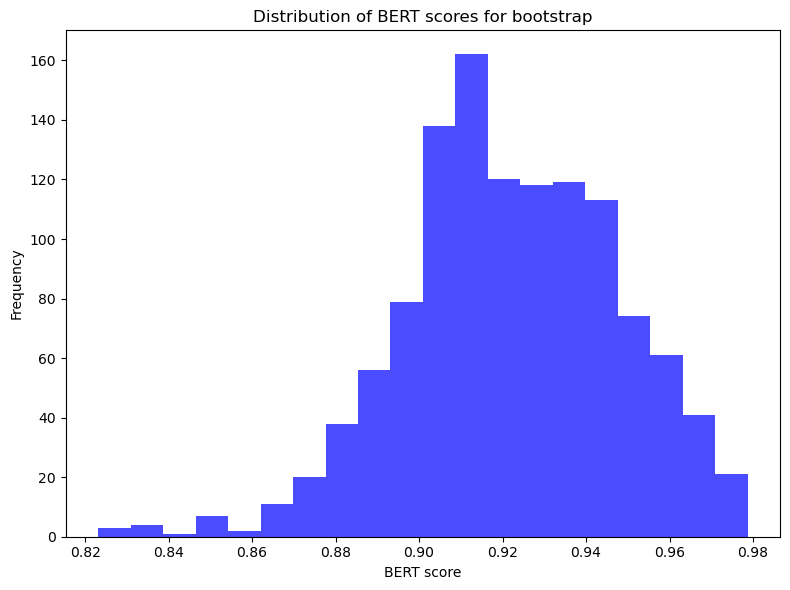

In [16]:
# Create a figure with subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of BERT scores for p1
ax.hist(bootstrap_df['bertscore'], bins=20, color='blue', alpha=0.7)
ax.set_title('Distribution of BERT scores for bootstrap')
ax.set_xlabel('BERT score')
ax.set_ylabel('Frequency')

plt.tight_layout()

# Save the plot to a file (e.g., a PDF file)
path_to_plot_file = f"{os.getcwd()}/plots/bootstrap_correct_only_all_paraphrases-BERTscores-distribution.pdf"
plt.savefig(path_to_plot_file)

plt.show()


## TED score distribution

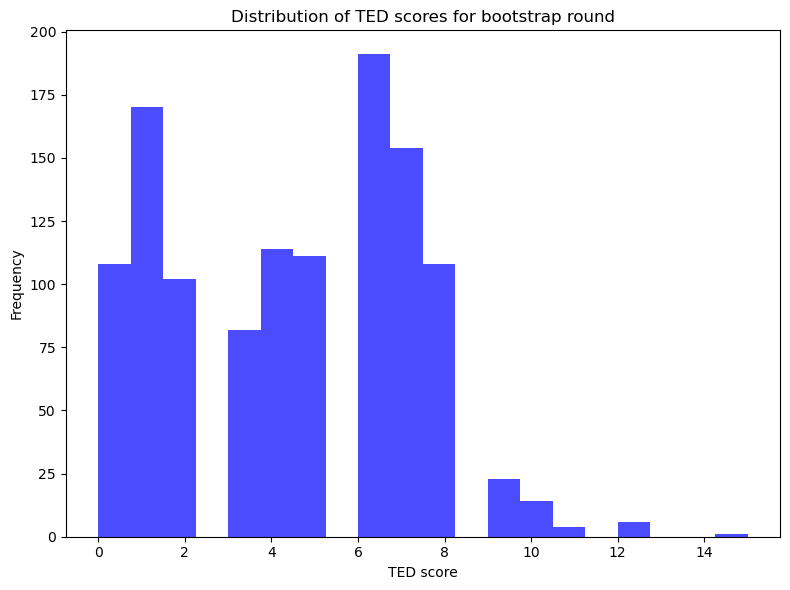

In [15]:
# Create a figure with subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of BERT scores for p1
ax.hist(bootstrap_df['ted'], bins=20, color='blue', alpha=0.7)
ax.set_title('Distribution of TED scores for bootstrap round')
ax.set_xlabel('TED score')
ax.set_ylabel('Frequency')

plt.tight_layout()

# Save the plot to a file (e.g., a PDF file)
path_to_plot_file = f"{os.getcwd()}/plots/bootstrap_correct_only_all_paraphrases-TEDscores-distribution.pdf"
plt.savefig(path_to_plot_file)

plt.show()


In [10]:
print(f"BERT Mean: {bootstrap_df['bertscore'].mean()}")
print(f"BERT Median: {bootstrap_df['bertscore'].median()}")
print(f"BERT standard deviation: {bootstrap_df['bertscore'].std()}")

print(f"TED Mean: {bootstrap_df['ted'].mean()}")
print(f"TED Median: {bootstrap_df['ted'].median()}")
print(f"TED standard deviation: {bootstrap_df['ted'].std()}")

BERT Mean: 0.92199398506734
BERT Median: 0.92106083
BERT standard deviation: 0.025769196774272366
TED Mean: 4.374579124579125
TED Median: 5.0
TED standard deviation: 2.806646385620988


### **Metrics scores**

In [22]:
def compute_metrics(df, input_utterance):
    df_s = df[df["input_utterance"] == input_utterance]
    paraphrases = df_s["paraphrase_value"].values
    ttr_metric = metrics.compute_ttr(input_utterance, paraphrases)
    pincs = [metrics.compute_pinc(input_utterance, p) for p in paraphrases]
    mean_pinc = sum(pincs) / len(pincs)
    div = metrics.compute_div({input_utterance: paraphrases})
    return ttr_metric["ttr"], mean_pinc, div

def compute_metrics_for_df(df):
    ttrs = []
    mean_pincs = []
    divs = []

    for iu in df["input_utterance"].unique():
        ttr, mean_pinc, div = compute_metrics(df, iu)  # Assuming you have a function 'compute_metrics' that takes df and iu as arguments
        ttrs.append(ttr)
        mean_pincs.append(mean_pinc)
        divs.append(div)

    ttrs = np.array(ttrs)
    mean_pincs = np.array(mean_pincs)
    divs = np.array(divs)
    return ttrs, mean_pincs, divs

In [20]:
def compute_metrics_condition_all(df,condition):

    ttrs = []
    mean_pincs = []
    iu_dataset = {}

    for iu in tqdm(df["input_utterance"].unique(), position=0, leave=True, desc = f"Handled input utterance for {condition}"):
        ttr, mean_pinc,_ = compute_metrics(df, iu)
        ttrs.append(ttr)
        mean_pincs.append(mean_pinc)
        iu_dataset[iu] = df[df["input_utterance"] == iu]["paraphrase_value"].values
    

    ttrs = np.array(ttrs)
    mean_pincs = np.array(mean_pincs)
    with tqdm(total=3, position=0, leave=True, desc="Calculating metrics") as pbar:
        div_score = metrics.compute_div(iu_dataset)
        pbar.update(1)
        
        bleu_score = metrics.compute_corpus_bleu(iu_dataset)
        pbar.update(1)
        
        gleu_score = metrics.compute_corpus_gleu(iu_dataset)
        pbar.update(1)
    
    return {"condition": condition, "mean_ttr": ttrs.mean(), "mean_pinc": mean_pincs.mean(), "div": div_score, 
            "bleu": bleu_score, "gleu": gleu_score, "bertscore": df.bertscore.mean()}

In [23]:
metrics_summary = compute_metrics_condition_all(bootstrap_df, "bootstrap")
metrics_summary

Calculating metrics: 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


{'condition': 'bootstrap',
 'mean_ttr': 0.15388436459305432,
 'mean_pinc': 0.44840821686024296,
 'div': 0.7456604961664647,
 'bleu': 0.009746372333602088,
 'gleu': 0.013959789753367646,
 'bertscore': 0.92199398506734}

### Count how many time TED = 0

In [8]:
TED_value = 0
count = bootstrap_df['ted'].value_counts()[TED_value]
print(f"TED = {TED_value} occured {count}")

TED_value = 1
count = bootstrap_df['ted'].value_counts()[TED_value]
print(f"TED = {TED_value} occured {count}")

TED_value = 2
count = bootstrap_df['ted'].value_counts()[TED_value]
print(f"TED = {TED_value} occured {count}")

TED_value = 3
count = bootstrap_df['ted'].value_counts()[TED_value]
print(f"TED = {TED_value} occured {count}")

TED = 0 occured 108
TED = 1 occured 170
TED = 2 occured 102
TED = 3 occured 82
